In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Mendownload Dataset
import opendatasets as od
od.download("https://www.kaggle.com/datasets/hendratno/covid19-indonesia")

Skipping, found downloaded files in ".\covid19-indonesia" (use force=True to force download)


# LOADING DATA

In [3]:
# Mendeklarasikan dataset menjadi variabel covid
covid = pd.read_csv('covid19-indonesia/covid_19_indonesia_time_series_all.csv')
covid.head(5)

Date Location ISO Code     Location  New Cases  New Deaths  \
0  3/1/2020             ID-JK  DKI Jakarta          2           0   
1  3/2/2020             ID-JK  DKI Jakarta          2           0   
2  3/2/2020               IDN    Indonesia          2           0   
3  3/2/2020             ID-RI         Riau          1           0   
4  3/3/2020             ID-JK  DKI Jakarta          2           0   

   New Recovered  New Active Cases  Total Cases  Total Deaths  \
0              0                 2           39            20   
1              0                 2           41            20   
2              0                 2            2             0   
3              0                 1            1             0   
4              0                 2           43            20   

   Total Recovered  ...  Latitude New Cases per Million  \
0               75  ... -6.204699                  0.18   
1               75  ... -6.204699                  0.18   
2                0  ... -0.789275                  0.01   
3                1  ...  0.511648                  0.16   
4               75  ... -6.204699                  0.18   

   Total Cases per Million New Deaths per Million Total Deaths per Million  \
0                     3.60                    0.0                     1.84   
1                     3.78                    0.0                     1.84   
2                     0.01                    0.0                     0.00   
3                     0.16                    0.0                     0.00   
4                     3.96                    0.0                     1.84   

  Total Deaths per 100rb Case Fatality Rate Case Recovered Rate  \
0                   0.18             51.28%             192.31%   
1                   0.18             48.78%             182.93%   
2                   0.00              0.00%               0.00%   
3                   0.00              0.00%             100.00%   
4                   0.18             46.51%             174.42%   

  Growth Factor of New Cases  Growth Factor of New Deaths  
0                        NaN                          NaN  
1                        1.0                          1.0  
2                        NaN                          NaN  
3                        NaN                          NaN  
4                        1.0                          1.0  

[5 rows x 38 columns]

# PREPROCESSING DATA

In [4]:
# Menghapus kolom tidak relevan
covid = covid.drop(['Location ISO Code', 'Location Level', 'City or Regency', 'Province', 
            'Country', 'Continent', 'Island', 'Time Zone', 'Special Status', 'Total Regencies', 
            'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 
            'Longitude', 'New Cases per Million', 'Total Cases per Million', 'New Deaths per Million',
            'Total Deaths per Million',  'Total Deaths per 100rb', 'Latitude', 'Case Recovered Rate',
            'Growth Factor of New Cases', 'Growth Factor of New Deaths'], axis=1)

In [5]:
# Mengubah tipe data Date menjadi datetime
covid['Date'] = pd.to_datetime(covid['Date'])

# Memfilter data yang relevan (di sini hanya menggunakan data pada tahun 2021)
covid21 = covid.loc[covid['Date'].dt.year == 2021]
covid21 = covid21.reset_index(drop=True)
covid21.head(5)

Date     Location  New Cases  New Deaths  New Recovered  \
0 2021-01-01         Aceh          7           0             10   
1 2021-01-01         Bali        101           1             76   
2 2021-01-01       Banten        287          12            188   
3 2021-01-01     Bengkulu         68           5             97   
4 2021-01-01  DKI Jakarta       1956          20           1643   

   New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                -3         8753           358             7150   
1                24        17694           517            16223   
2                87        18441           537            15881   
3               -34         3671           117             2652   
4               293       185690          3290           166383   

   Total Active Cases  Area (km2)  Population  Population Density  \
0                1245       57956     5247257               90.54   
1                 954        5780     4216171              729.43   
2                2023        9663    10722374             1109.64   
3                 902       19919     1999539              100.38   
4               16017         664    10846145            16334.31   

  Case Fatality Rate  
0              4.09%  
1              2.92%  
2              2.91%  
3              3.19%  
4              1.77%

In [6]:
# Mengubah tipe data Case Fatality Rate menjadi Float
covid21['Case Fatality Rate'] = covid21['Case Fatality Rate'].apply(lambda x: float(x[:-1]))
covid21.head(5)

Date     Location  New Cases  New Deaths  New Recovered  \
0 2021-01-01         Aceh          7           0             10   
1 2021-01-01         Bali        101           1             76   
2 2021-01-01       Banten        287          12            188   
3 2021-01-01     Bengkulu         68           5             97   
4 2021-01-01  DKI Jakarta       1956          20           1643   

   New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                -3         8753           358             7150   
1                24        17694           517            16223   
2                87        18441           537            15881   
3               -34         3671           117             2652   
4               293       185690          3290           166383   

   Total Active Cases  Area (km2)  Population  Population Density  \
0                1245       57956     5247257               90.54   
1                 954        5780     4216171              729.43   
2                2023        9663    10722374             1109.64   
3                 902       19919     1999539              100.38   
4               16017         664    10846145            16334.31   

   Case Fatality Rate  
0                4.09  
1                2.92  
2                2.91  
3                3.19  
4                1.77

In [7]:
# Mendapatkan informarsi mengenai variabel covid21
covid21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12775 entries, 0 to 12774
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12775 non-null  datetime64[ns]
 1   Location            12775 non-null  object        
 2   New Cases           12775 non-null  int64         
 3   New Deaths          12775 non-null  int64         
 4   New Recovered       12775 non-null  int64         
 5   New Active Cases    12775 non-null  int64         
 6   Total Cases         12775 non-null  int64         
 7   Total Deaths        12775 non-null  int64         
 8   Total Recovered     12775 non-null  int64         
 9   Total Active Cases  12775 non-null  int64         
 10  Area (km2)          12775 non-null  int64         
 11  Population          12775 non-null  int64         
 12  Population Density  12775 non-null  float64       
 13  Case Fatality Rate  12775 non-null  float64   

In [8]:
# Mendapatkan deskripsi lengkap mengenai variabel covid21
covid.describe()

Date     New Cases    New Deaths  \
count                          31822  31822.000000  31822.000000   
mean   2021-06-17 19:32:22.882282752    402.311388      9.920652   
min              2020-03-01 00:00:00      0.000000      0.000000   
25%              2020-11-03 00:00:00      3.000000      0.000000   
50%              2021-06-18 00:00:00     27.000000      0.000000   
75%              2022-01-31 00:00:00    130.000000      3.000000   
max              2022-09-16 00:00:00  64718.000000   2069.000000   
std                              NaN   2320.629838     64.139080   

       New Recovered  New Active Cases   Total Cases   Total Deaths  \
count   31822.000000      31822.000000  3.182200e+04   31822.000000   
mean      390.398498          1.992238  1.594500e+05    4564.753221   
min         0.000000     -29938.000000  1.000000e+00       0.000000   
25%         2.000000        -12.000000  5.223250e+03     128.000000   
50%        20.000000          0.000000  2.359650e+04     565.500000   
75%       123.000000         19.000000  6.992775e+04    2189.000000   
max     61361.000000      39165.000000  6.405044e+06  157876.000000   
std      2199.878802       1219.513355  6.264435e+05   17693.731369   

       Total Recovered  Total Active Cases    Area (km2)    Population  \
count     3.182200e+04        31822.000000  3.182200e+04  3.182200e+04   
mean      1.492615e+05         5623.782415  1.106532e+05  1.536766e+07   
min       0.000000e+00        -2343.000000  6.640000e+02  6.484070e+05   
25%       3.913500e+03           80.000000  1.678700e+04  1.999539e+06   
50%       2.102750e+04          557.000000  4.201300e+04  4.216171e+06   
75%       6.414200e+04         2279.000000  7.546800e+04  9.095591e+06   
max       6.218708e+06       586113.000000  1.916907e+06  2.651855e+08   
std       5.958536e+05        28537.412305  3.187865e+05  4.461714e+07   

       Population Density  
count        31822.000000  
mean           738.894928  
min              8.590000  
25%             47.790000  
50%            103.840000  
75%            262.700000  
max          16334.310000  
std           2729.431626

# EXPLORATORY DATA ANALYSIS (EDA)

### LINE CHART

In [9]:
# Membuat variabel all_reg yang berisi nilai unik dari kolom Location
all_reg = covid21['Location'].unique()
all_reg

array(['Aceh', 'Bali', 'Banten', 'Bengkulu', 'DKI Jakarta',
       'Daerah Istimewa Yogyakarta', 'Gorontalo', 'Indonesia', 'Jambi',
       'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat',
       'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur',
       'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau',
       'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat',
       'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Riau',
       'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah',
       'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat',
       'Sumatera Selatan', 'Sumatera Utara'], dtype=object)

In [10]:
# Mode Dual digunakan saat ingin melakukan komparasi data setiap provinsi dan nasional
# Step adalah perintah untuk mengatur data keberapa yang ingin digunakan

def linechart_percol(col:str, step:int, mode:str):
    titles = ['in Indonesia', 'for each province']

    if mode.lower() == 'dual':
        plt.figure(figsize=(20, 18))
        for i in range(2):
            plt.subplot(2, 1, i + 1)
            for reg in all_reg:
                if reg == 'Indonesia' and i == 1:
                    continue
                plt.plot(covid21['Date'].unique()[::step], covid21[col].loc[covid21['Location'] == reg].iloc[::step], label = reg)
            plt.title(f'{col} of Covid 19 {titles[i]} in 2021')
            plt.legend(loc='upper right', fontsize=8)
            plt.xlabel('Date')
            plt.ylabel(col)
        plt.show()
        

    elif mode.lower() == 'single':
        plt.figure(figsize=(20, 8))
        for reg in all_reg:
            if reg == 'Indonesia':
                continue
            plt.plot(covid21['Date'].unique()[::step], covid21[col].loc[covid21['Location'] == reg].iloc[::step], label = reg)
        plt.title(f'{col} of Covid 19 {titles[-1]} in 2021')
        plt.legend(loc='upper right', fontsize=8)
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.show()

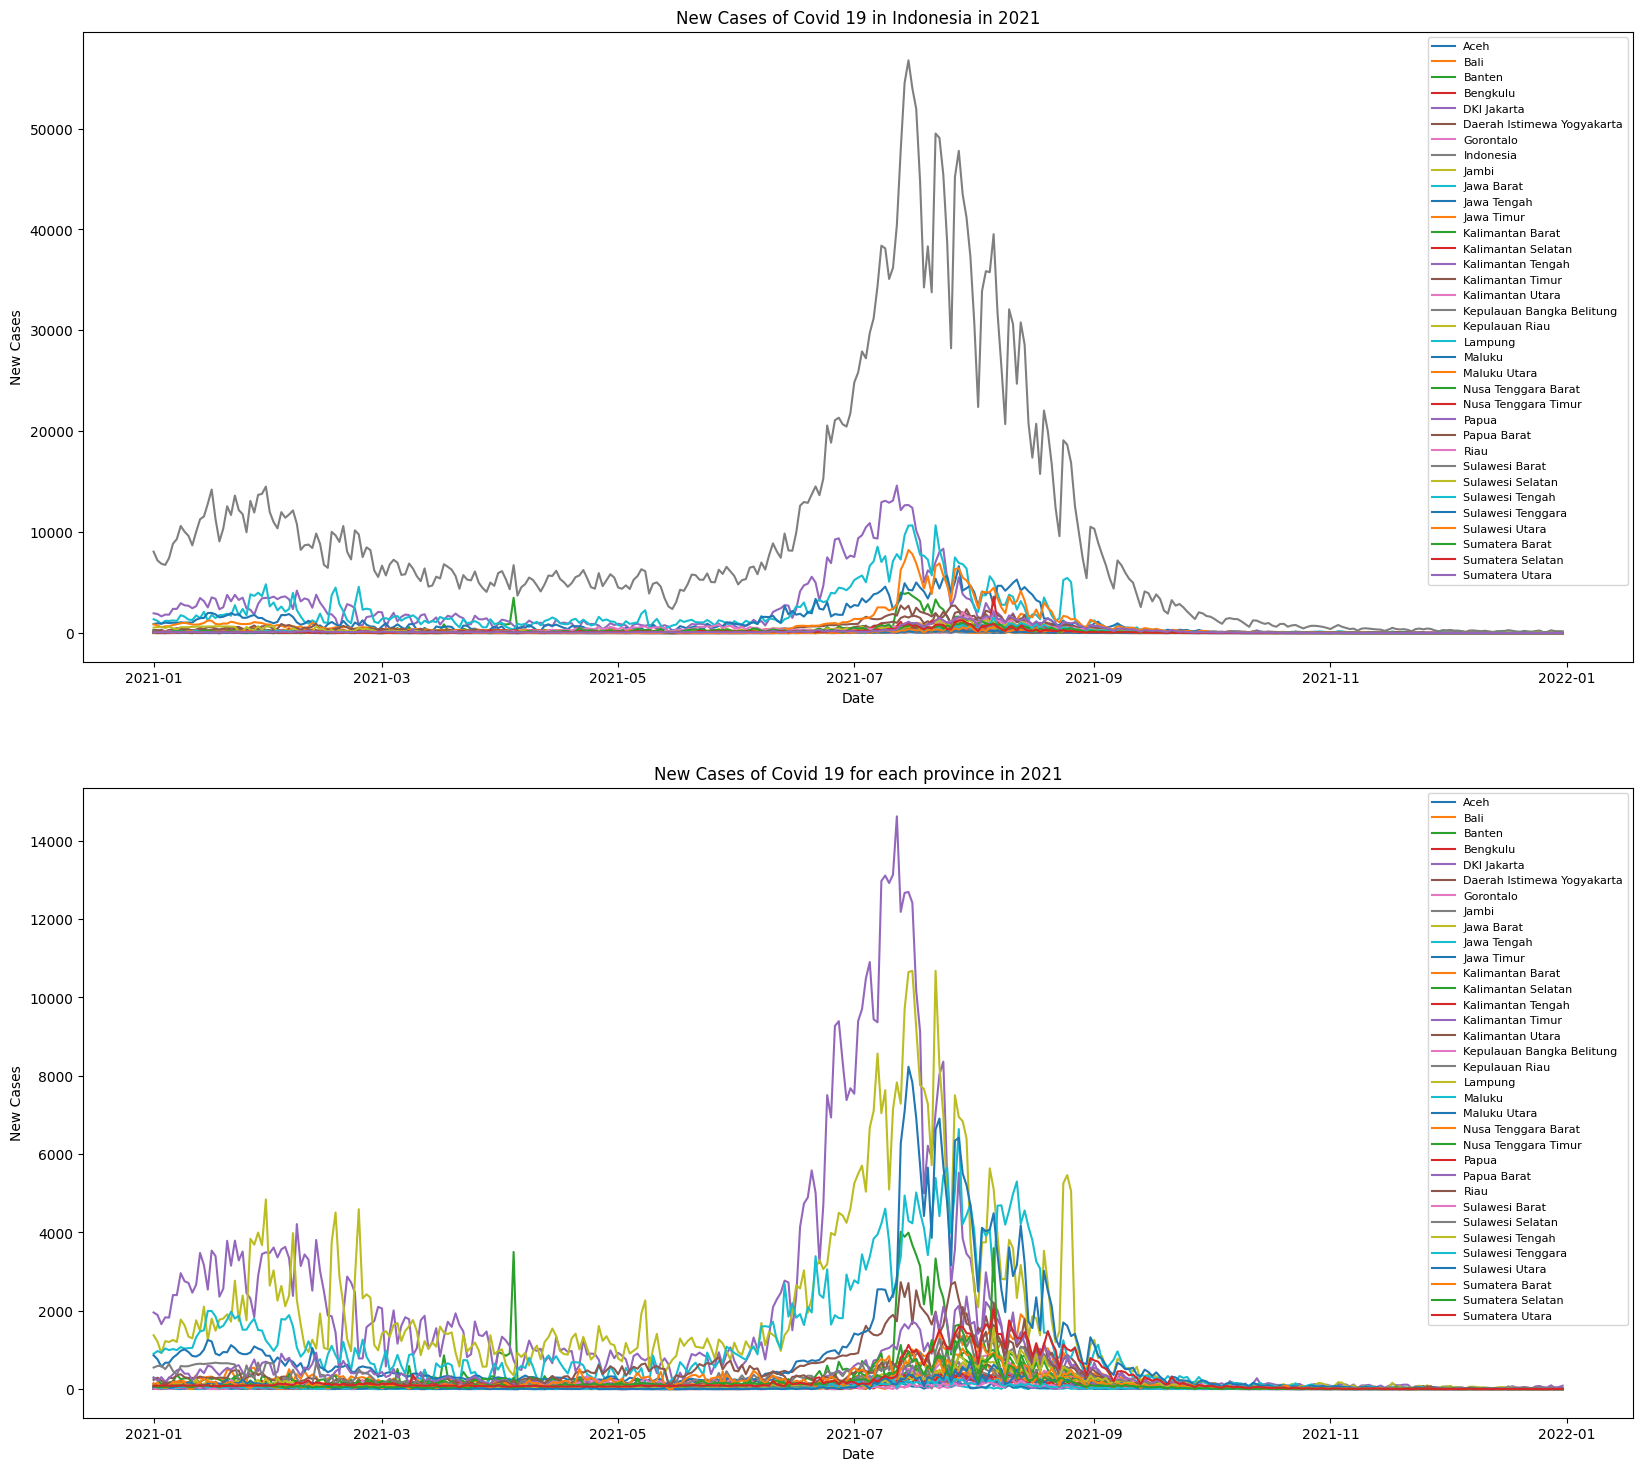

In [11]:
# Membuat grafik garis pada kolom New Cases dengan step 1 dan mode dual
linechart_percol('New Cases', 1, 'dual')

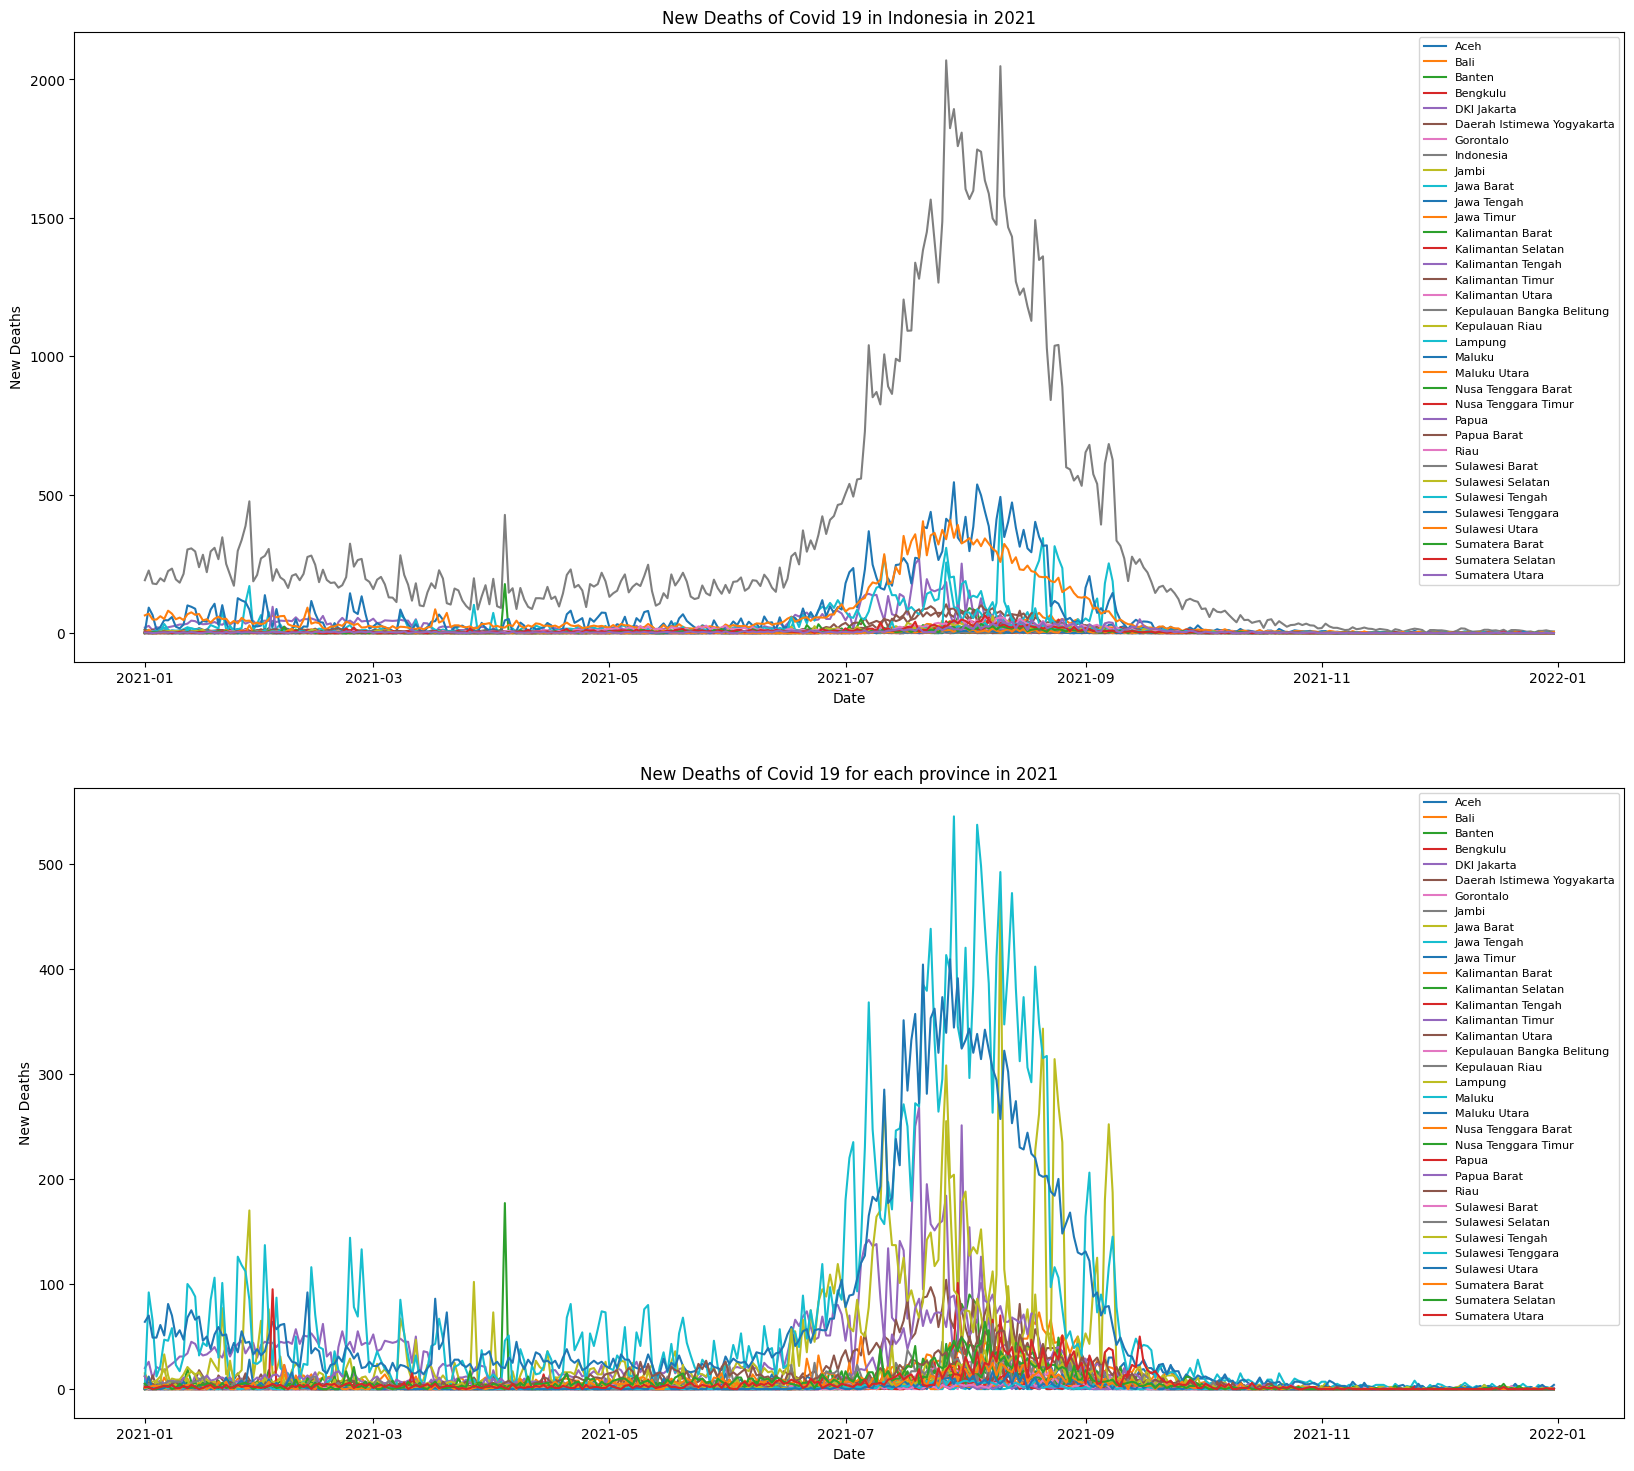

In [12]:
# Membuat grafik garis pada kolom New Deaths dengan step 1 dan mode dual
linechart_percol('New Deaths', 1,  'dual')

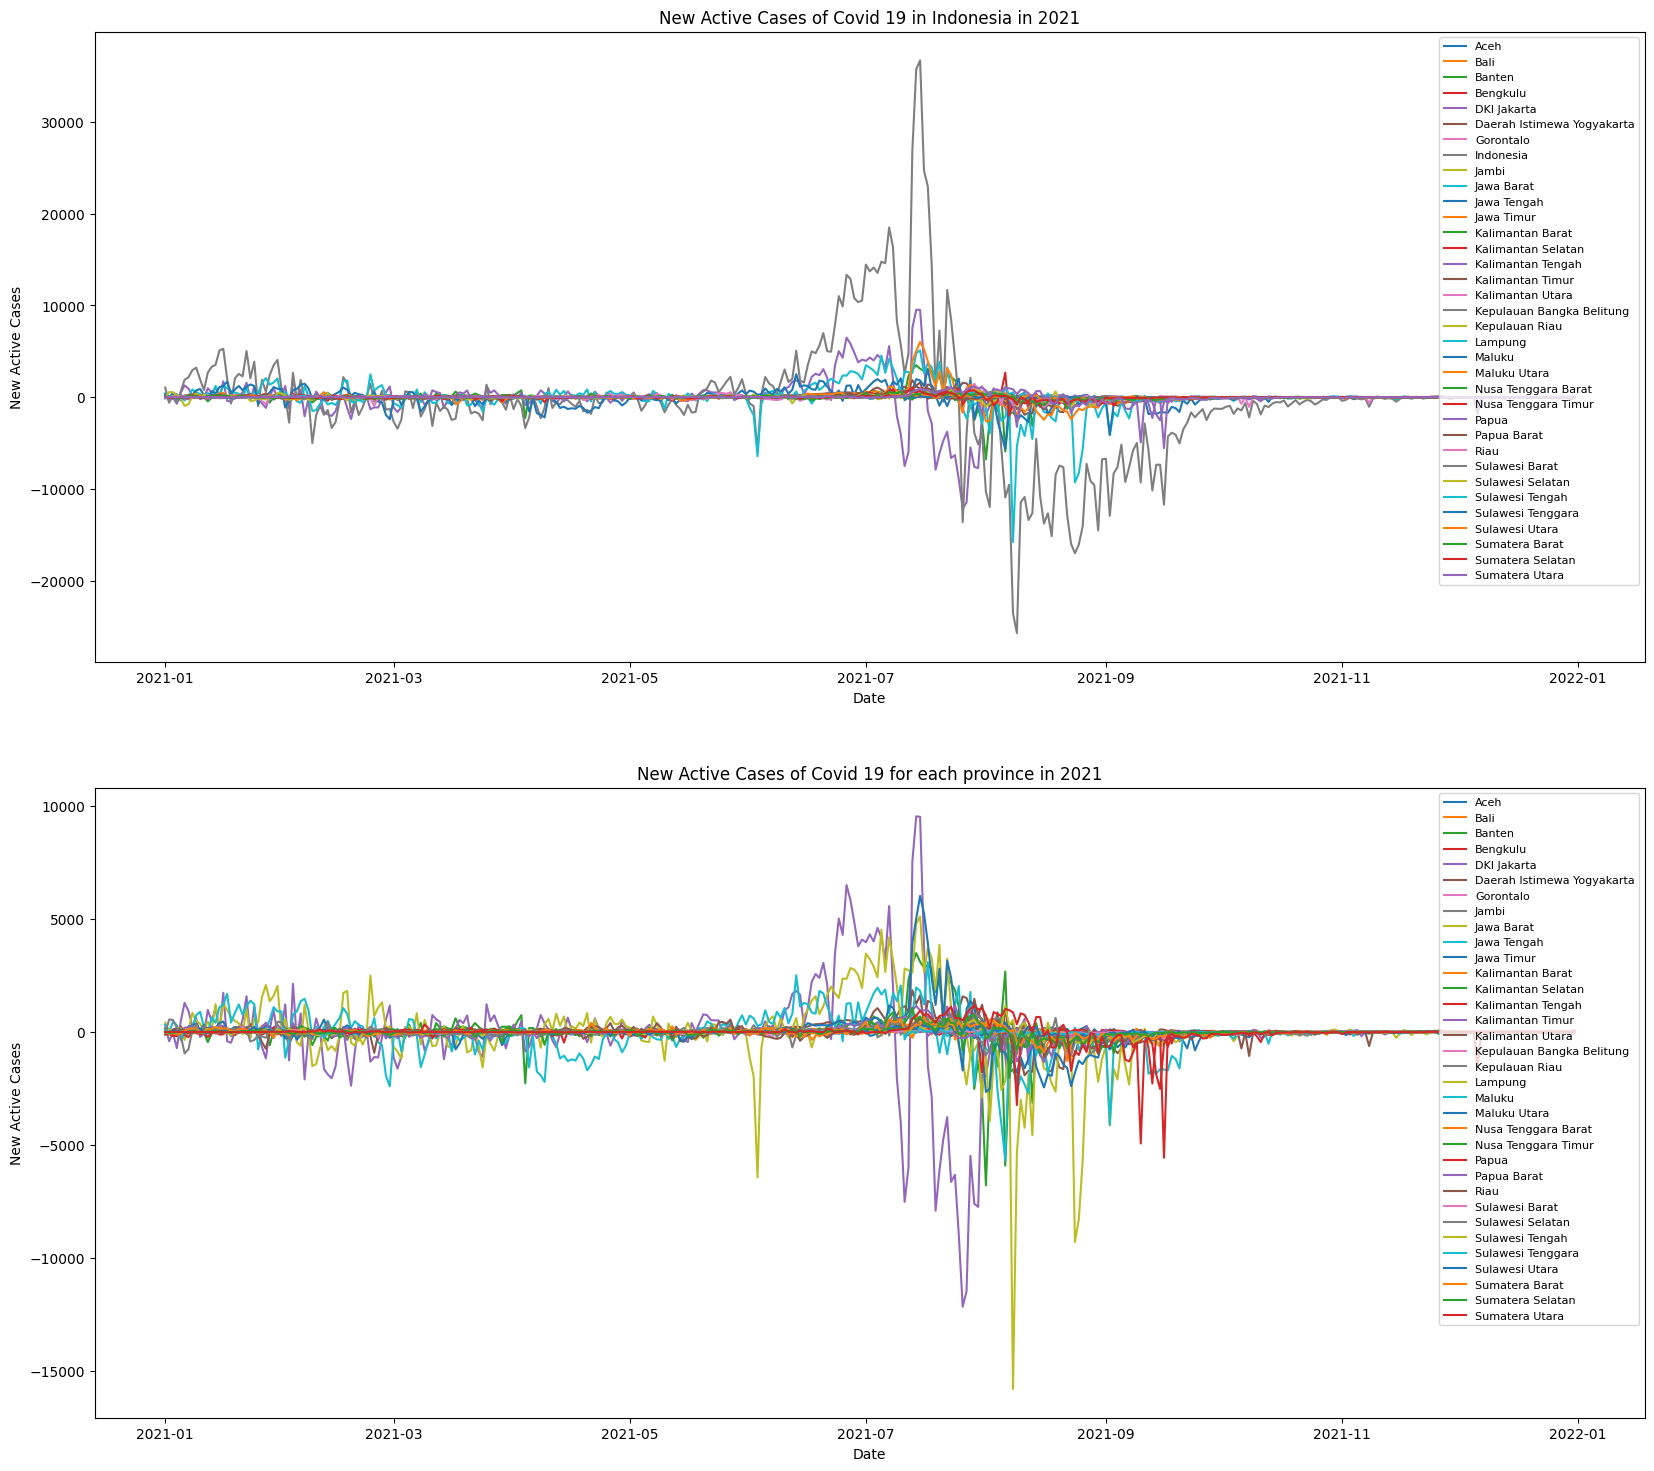

In [13]:
# Membuat grafik garis pada kolom New Active Cases dengan step 1 dan mode dual
linechart_percol('New Active Cases', 1, 'dual')

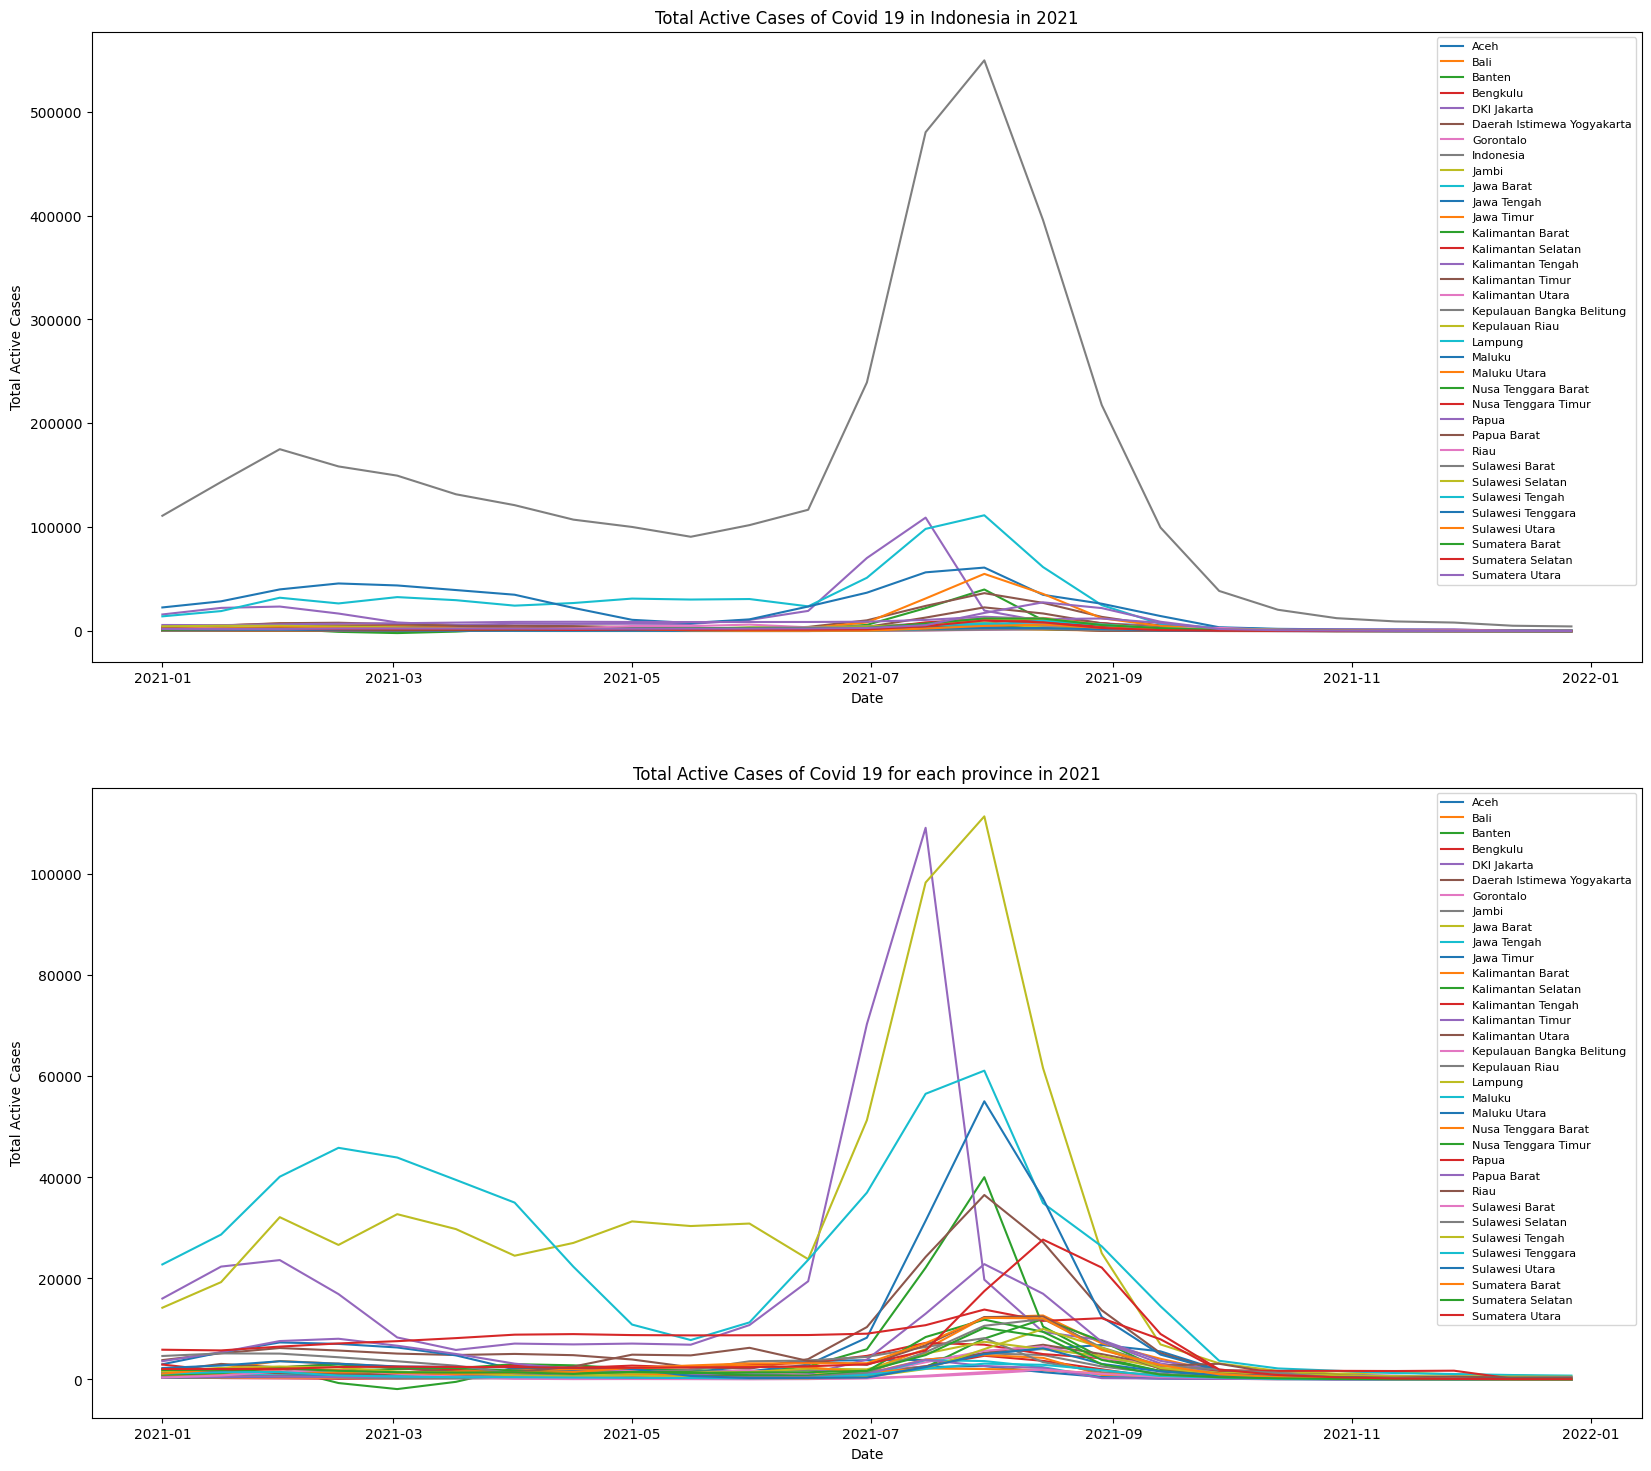

In [14]:
# Membuat grafik garis pada kolom Total Active Cases dengan step 15 dan mode dual
linechart_percol('Total Active Cases', 15, 'dual')

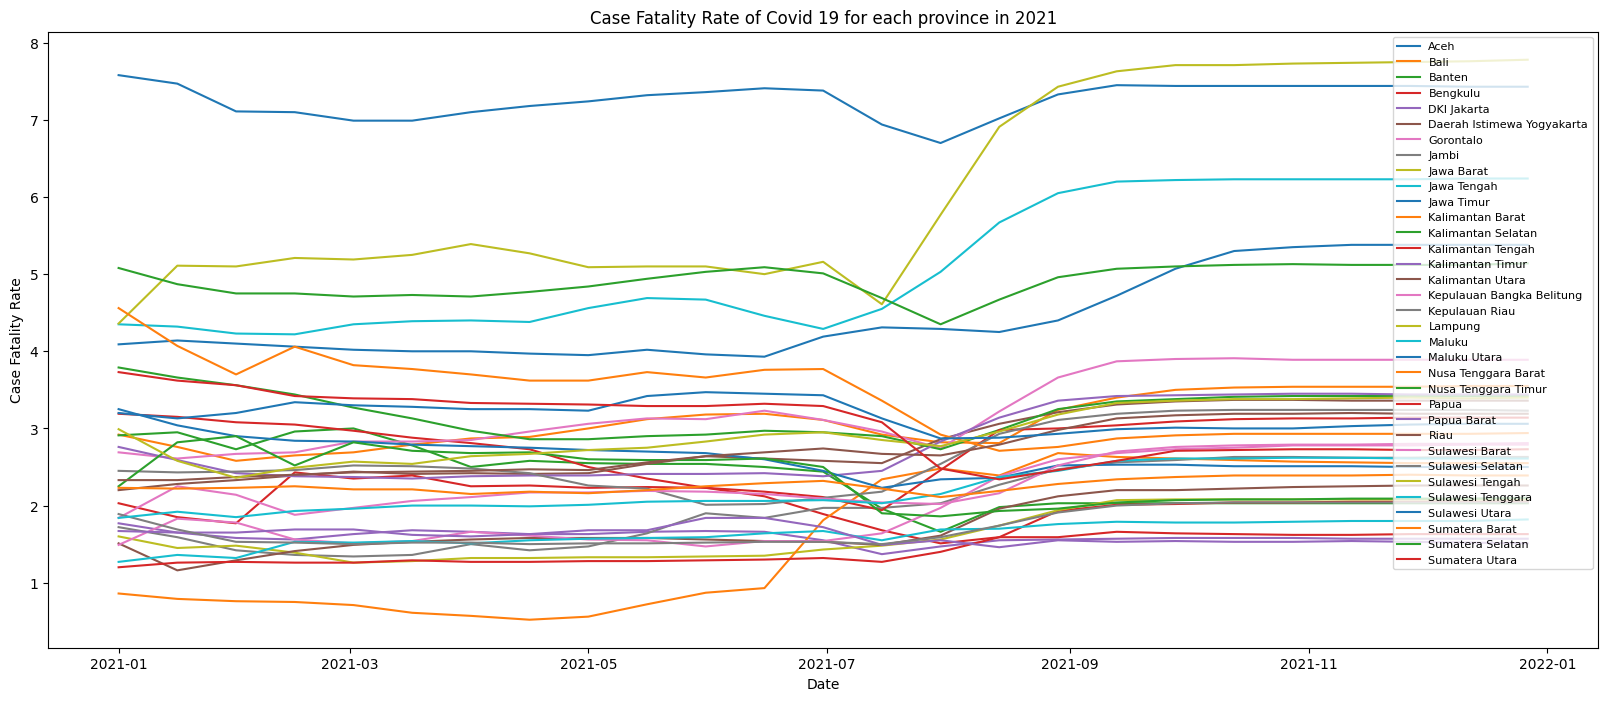

In [15]:
# Membuat grafik garis pada kolom Case Fatality Rate dengan step 15 dan mode single
linechart_percol('Case Fatality Rate', 15, 'single')

### BAR CHART

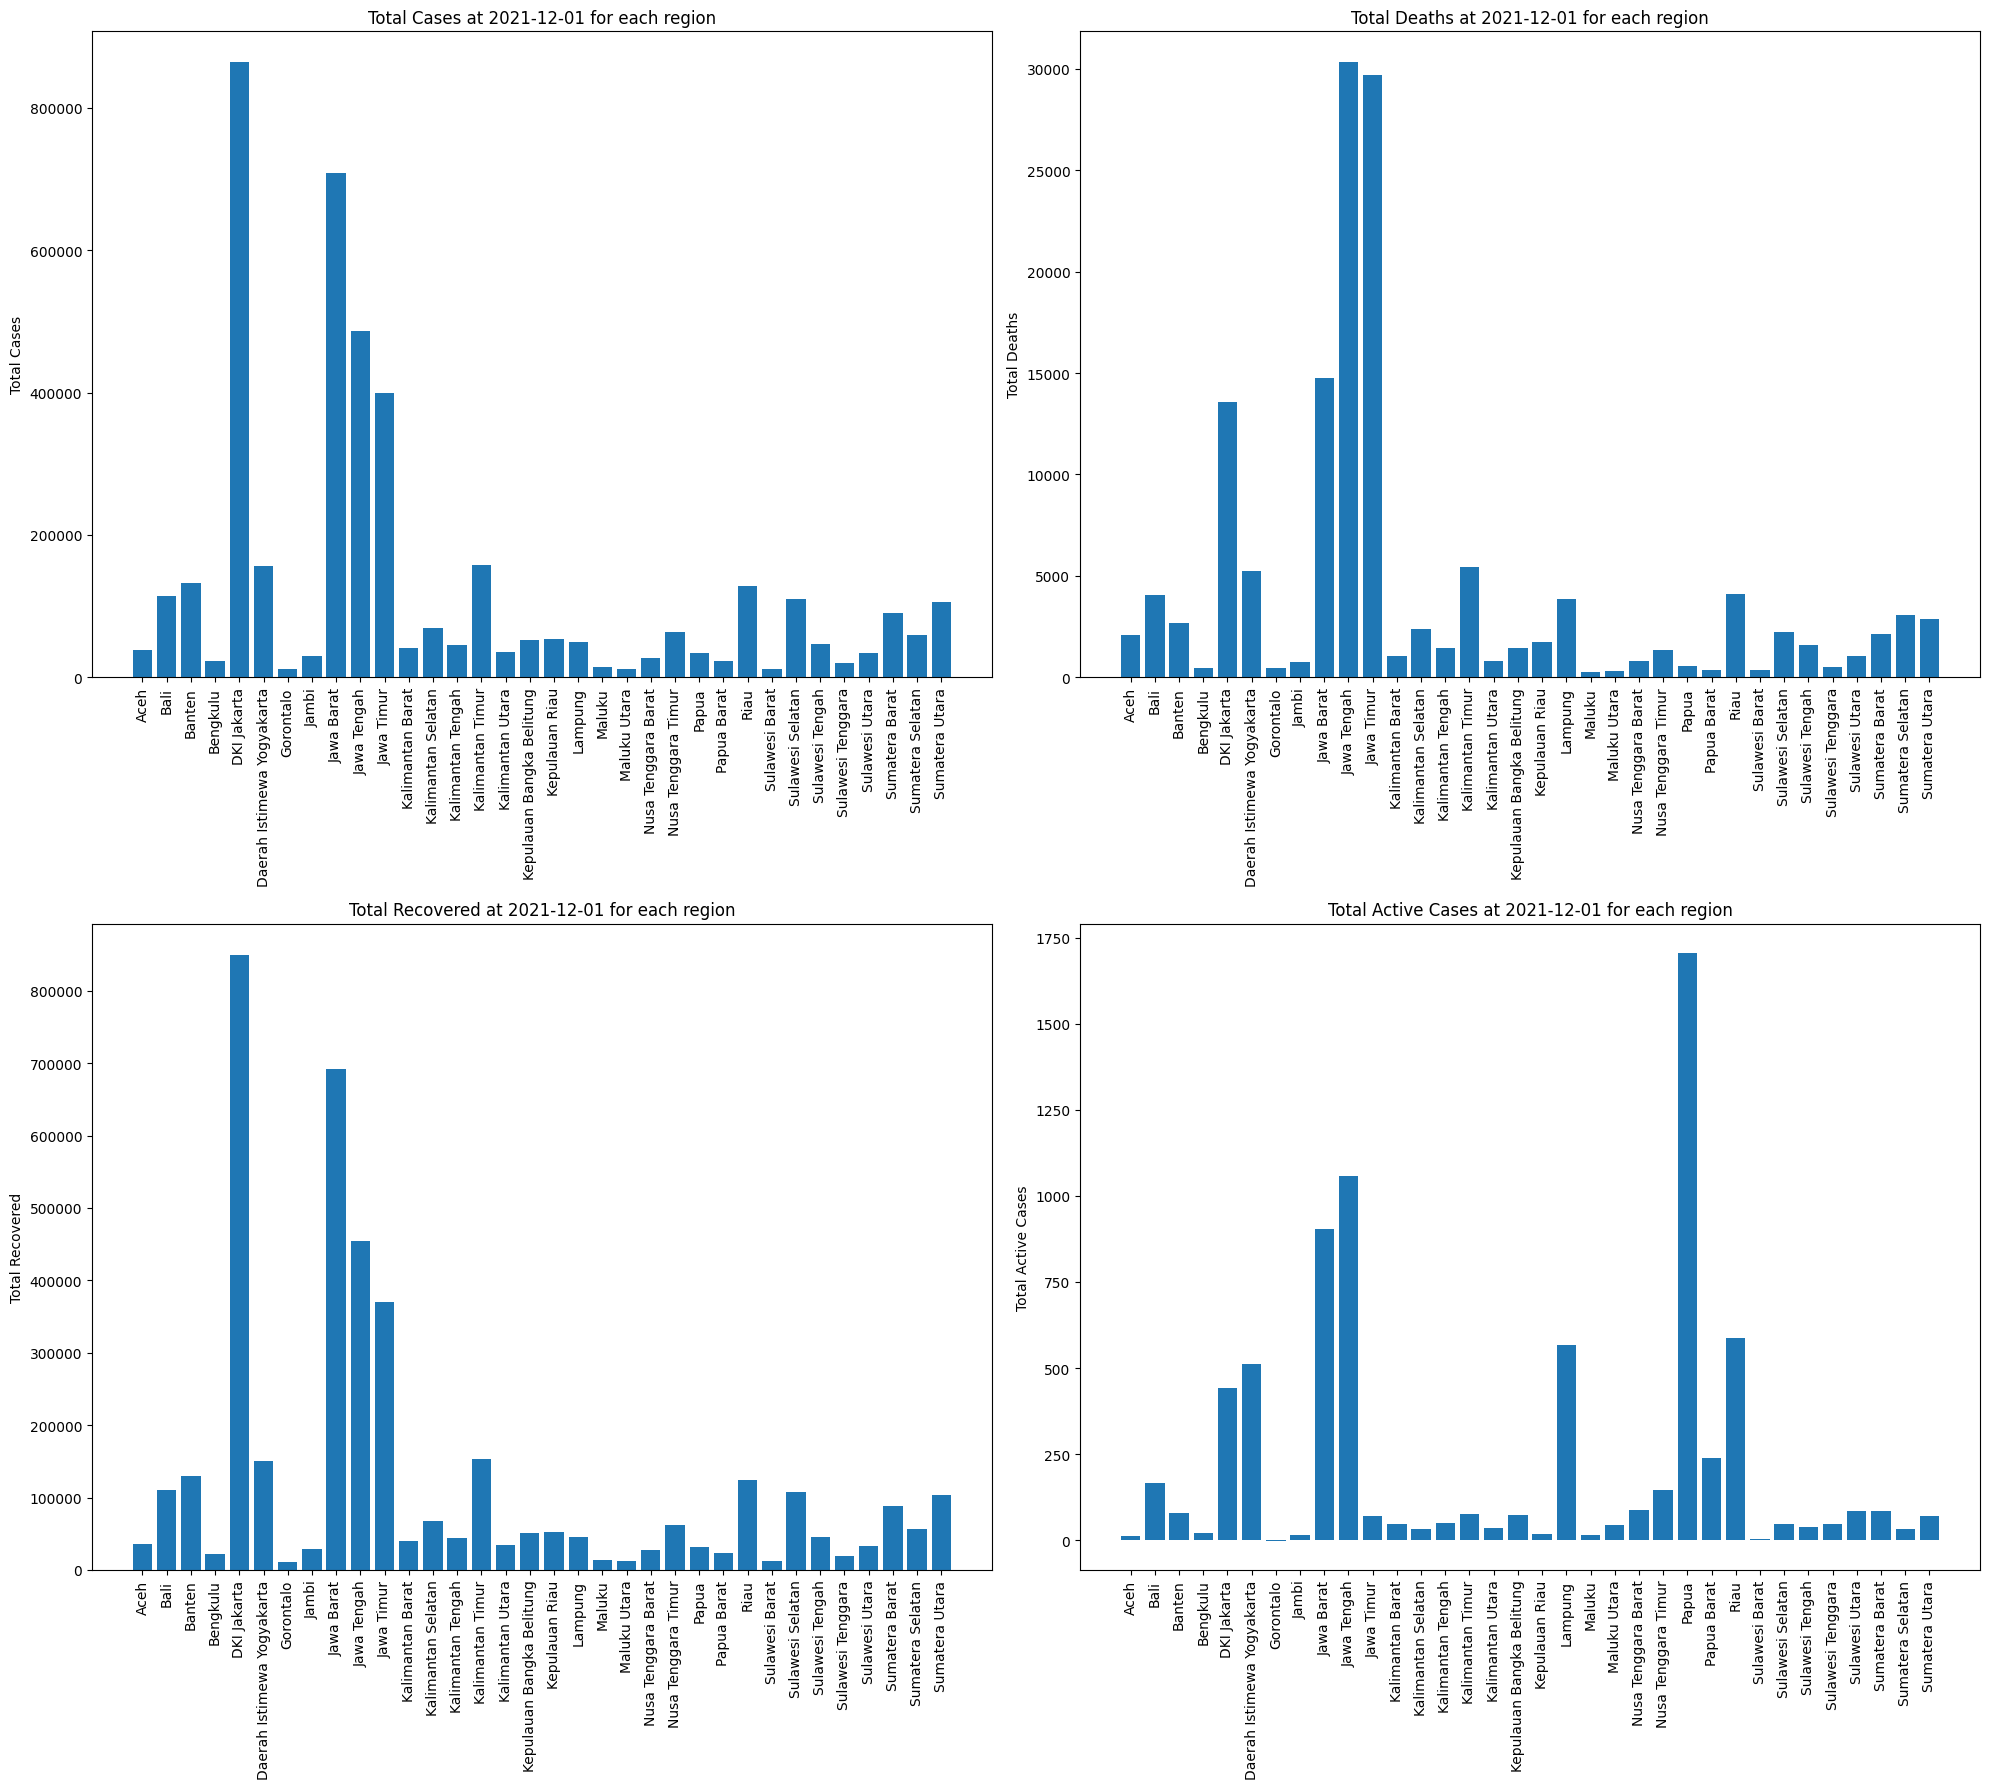

In [16]:
# Membuat grafik batang pada case-case di atas
values_col = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases']
datte = '2021-12-01'

plt.figure(figsize=(20, 18))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    labels = covid21['Location'].loc[covid21['Date'] == datte].tolist()
    values = covid21[values_col[i]].loc[covid21['Date'] == datte].tolist()

    country_index = labels.index('Indonesia')
    del labels[country_index]
    del values[country_index]

    plt.bar(labels, values)
    plt.title(f'{values_col[i]} at {datte} for each region')
    plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
    plt.ylabel(values_col[i])
plt.tight_layout()
plt.show()

In [17]:
# Mode Include country digunakan saat ingin memasukkan data indonesia pada label
# Mode Barlabel digunakan saat ingin memasukkan label pada bagian atas bar

def barplot_percol(values_col:str, datte:str, include_country:bool, barlabel:bool):
    labels = covid21['Location'].loc[covid21['Date'] == datte].tolist()
    values = covid21[values_col].loc[covid21['Date'] == datte].tolist()
    
    if include_country == False:
        country_index = labels.index('Indonesia')
        del labels[country_index]
        del values[country_index]

    plt.figure(figsize=(15, 8))
    plt.title(f'{values_col} at {datte} for each region')
    container = plt.bar(labels, values)
    if barlabel == True:
        plt.bar_label(container)
    plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
    plt.ylabel(values_col)
    
    plt.show()

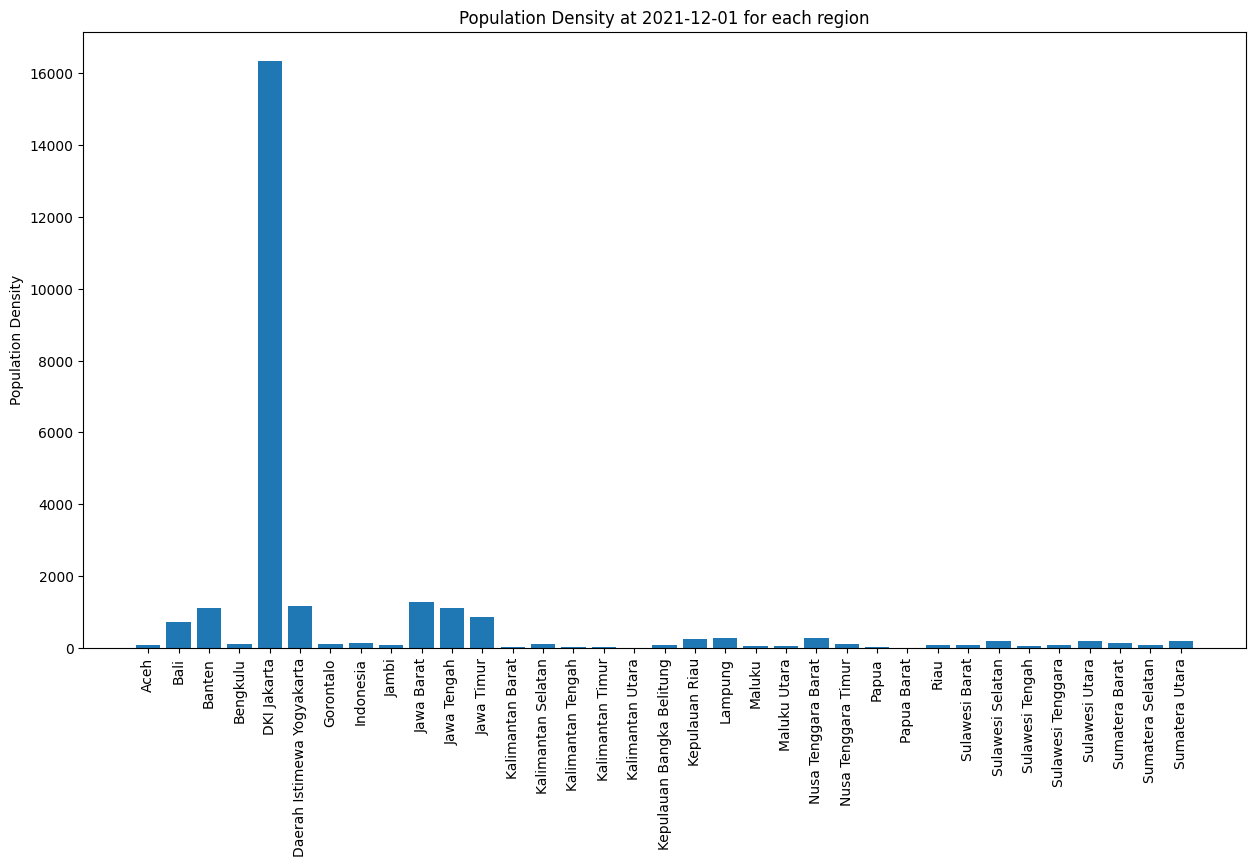

In [18]:
# Menyajikan grafik batang untuk menampilkan kepadatan penduduk setiap provinsi
barplot_percol('Population Density', '2021-12-01', True, False)

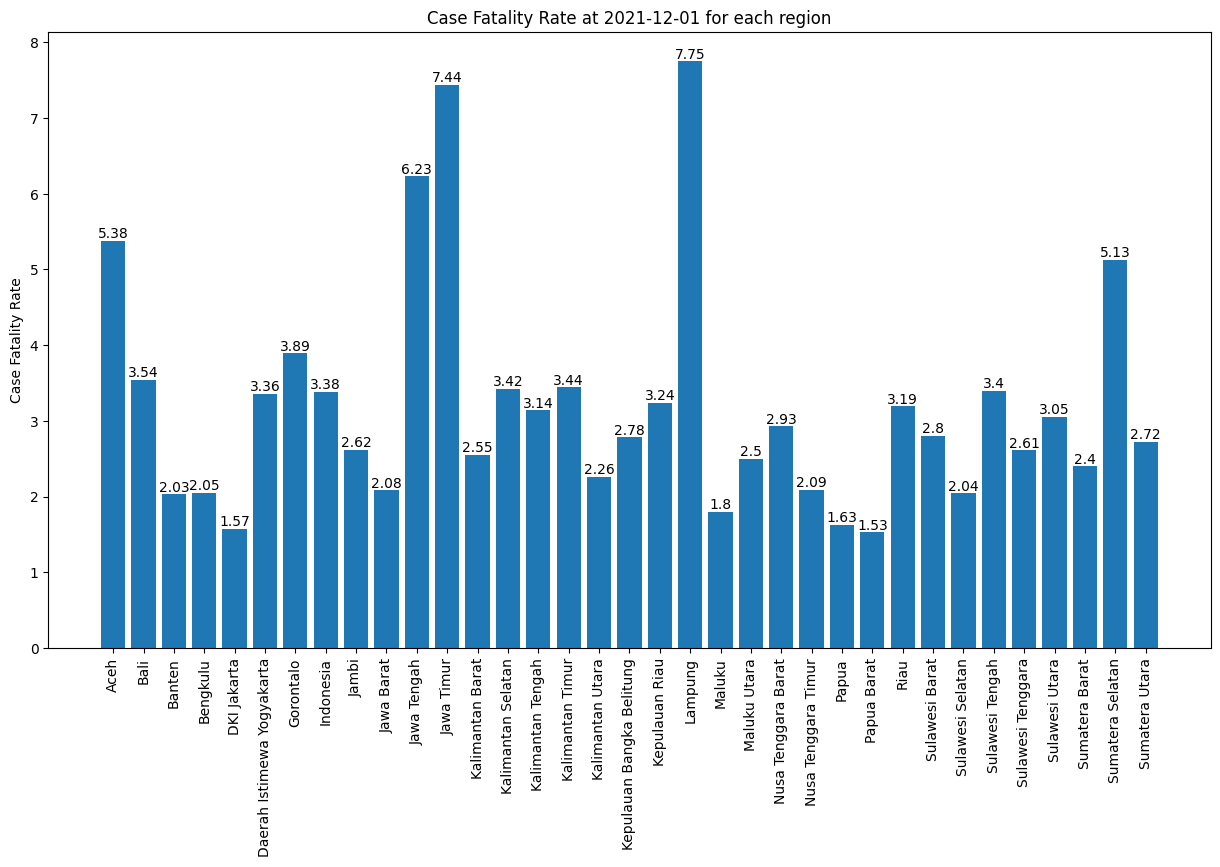

In [19]:
# Menyajikan grafik batang untuk menampilkan tingkat kematian penduduk akibat COVID-19 setiap provinsi
barplot_percol('Case Fatality Rate', '2021-12-01', True, True)

### HEAT MAP

In [20]:
# Membuat variabel baru dengan nama hm_data
hm_data = covid21.copy()
hm_data = hm_data.drop(columns=['Date', 'Location', 'Population', 'Area (km2)'])
hm_data = hm_data.corr()
round(hm_data, 2)
hm_data.head()

New Cases  New Deaths  New Recovered  New Active Cases  \
New Cases          1.000000    0.882639       0.893660          0.227030   
New Deaths         0.882639    1.000000       0.938162         -0.132621   
New Recovered      0.893660    0.938162       1.000000         -0.233972   
New Active Cases   0.227030   -0.132621      -0.233972          1.000000   
Total Cases        0.499857    0.533444       0.569235         -0.152452   

                  Total Cases  Total Deaths  Total Recovered  \
New Cases            0.499857      0.427395         0.452239   
New Deaths           0.533444      0.490300         0.488056   
New Recovered        0.569235      0.504452         0.524495   
New Active Cases    -0.152452     -0.170535        -0.158379   
Total Cases          1.000000      0.976317         0.998292   

                  Total Active Cases  Population Density  Case Fatality Rate  
New Cases                   0.949206            0.093048           -0.005409  
New Deaths                  0.922773            0.026640            0.076882  
New Recovered               0.943220            0.097219            0.001890  
New Active Cases            0.008326           -0.004041           -0.022035  
Total Cases                 0.566112            0.159119            0.053698

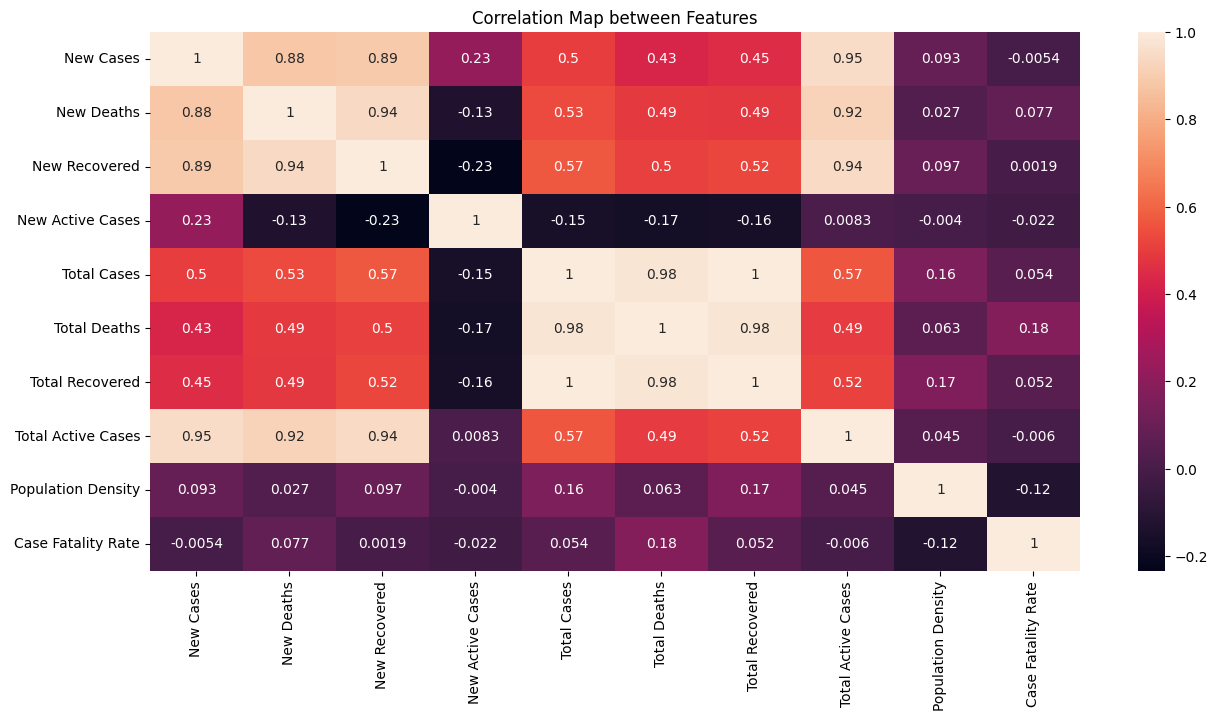

In [21]:
# Membuat map korelasi
plt.figure(figsize=(15, 7))
plt.title('Correlation Map between Features')
sns.heatmap(hm_data, annot=True)
del hm_data

# MODELING AND FEATURE ENGINEERING

### SCENARIO 1: Kmeans Clustering with only data at a certain date

#### Scenario 1.1: Using MinMax Scaler

In [22]:
datte = '2021-12-31'

covid21_eng = covid21.copy()
covid21_eng = covid21_eng.loc[covid21_eng['Date'] == datte]
X = covid21_eng.drop(columns=['Date', 'Location'])
X = X.reset_index(drop=True)
X.head()

New Cases  New Deaths  New Recovered  New Active Cases  Total Cases  \
0          1           0              0                 1        38430   
1          3           1              3                -1       114389   
2          4           0              3                 1       132826   
3          0           0              0                 0        23105   
4         87           1              0                86       865297   

   Total Deaths  Total Recovered  Total Active Cases  Area (km2)  Population  \
0          2066            36362                   2       57956     5247257   
1          4061           110273                  55        5780     4216171   
2          2694           130128                   4        9663    10722374   
3           473            22631                   1       19919     1999539   
4         13609           851236                 452         664    10846145   

   Population Density  Case Fatality Rate  
0               90.54                5.38  
1              729.43                3.55  
2             1109.64                2.03  
3              100.38                2.05  
4            16334.31                1.57

In [23]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

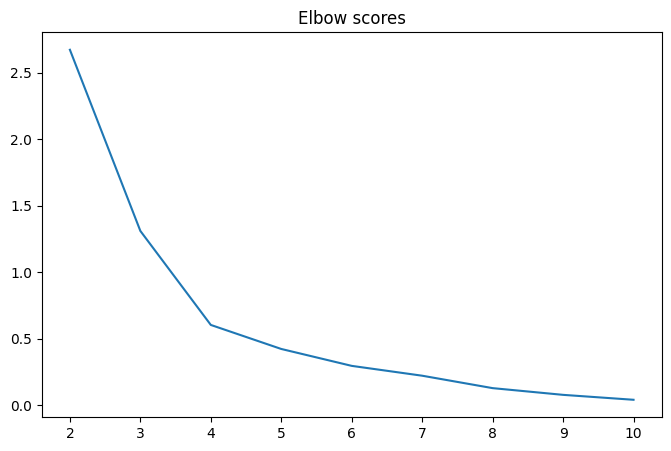

In [24]:
elbow_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    elbow_scores.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), elbow_scores)
plt.title('Elbow scores')
plt.show()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

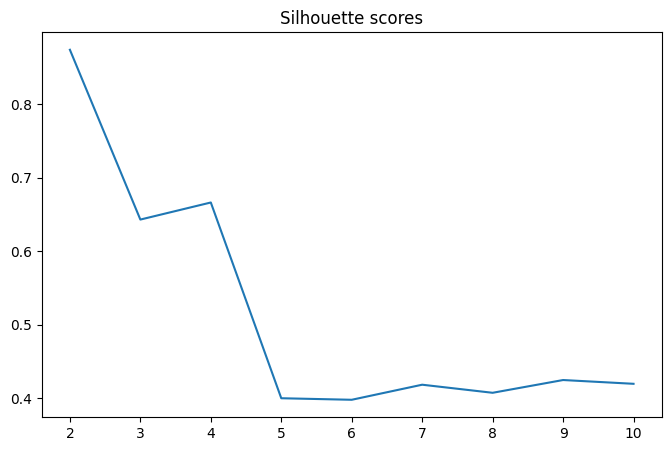

In [25]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    lab = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, lab))

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), silhouette_scores)
plt.title('Silhouette scores')
plt.show()

In [26]:
# Berdasarkan hasil elbow -> k optimal = 4
# Berdasarkan hasil silhouette -> k optimal = 2, tapi ada sedikit perbaikan di k = 4
# Keputusan cluster = 4
optimal_cluster = 4

In [27]:
kmeans = KMeans(n_clusters=optimal_cluster)
covid21_eng['Cluster'] = kmeans.fit_predict(X)
covid21_eng['PCA_1'] = X[:, 0]
covid21_eng['PCA_2'] = X[:, 1]
covid21_eng.head()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Date     Location  New Cases  New Deaths  New Recovered  \
12740 2021-12-31         Aceh          1           0              0   
12741 2021-12-31         Bali          3           1              3   
12742 2021-12-31       Banten          4           0              3   
12743 2021-12-31     Bengkulu          0           0              0   
12744 2021-12-31  DKI Jakarta         87           1              0   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
12740                 1        38430          2066            36362   
12741                -1       114389          4061           110273   
12742                 1       132826          2694           130128   
12743                 0        23105           473            22631   
12744                86       865297         13609           851236   

       Total Active Cases  Area (km2)  Population  Population Density  \
12740                   2       57956     5247257               90.54   
12741                  55        5780     4216171              729.43   
12742                   4        9663    10722374             1109.64   
12743                   1       19919     1999539              100.38   
12744                 452         664    10846145            16334.31   

       Case Fatality Rate  Cluster     PCA_1     PCA_2  
12740                5.38        0 -0.123649 -0.319254  
12741                3.55        3 -0.058245 -0.073146  
12742                2.03        3 -0.122697  0.173083  
12743                2.05        3 -0.169065  0.141202  
12744                1.57        2  0.269657  0.816142

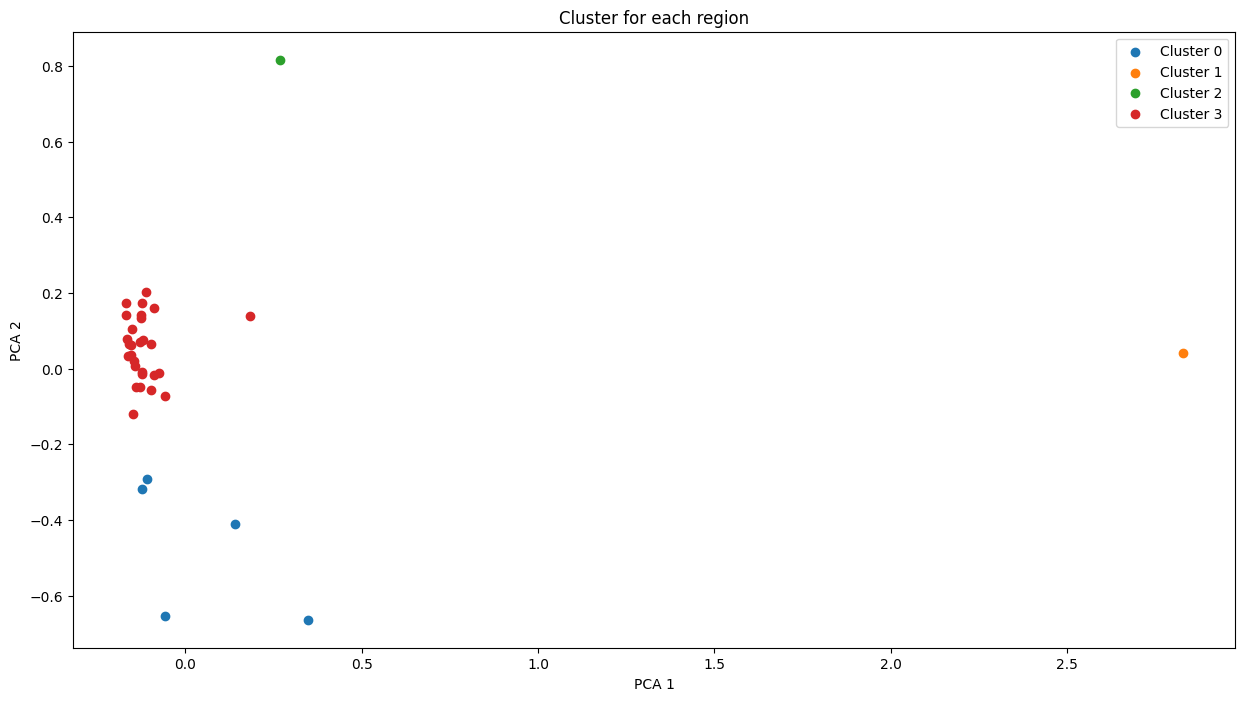

In [28]:
plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = covid21_eng['PCA_1'].loc[covid21_eng['Cluster'] == i]
    y = covid21_eng['PCA_2'].loc[covid21_eng['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

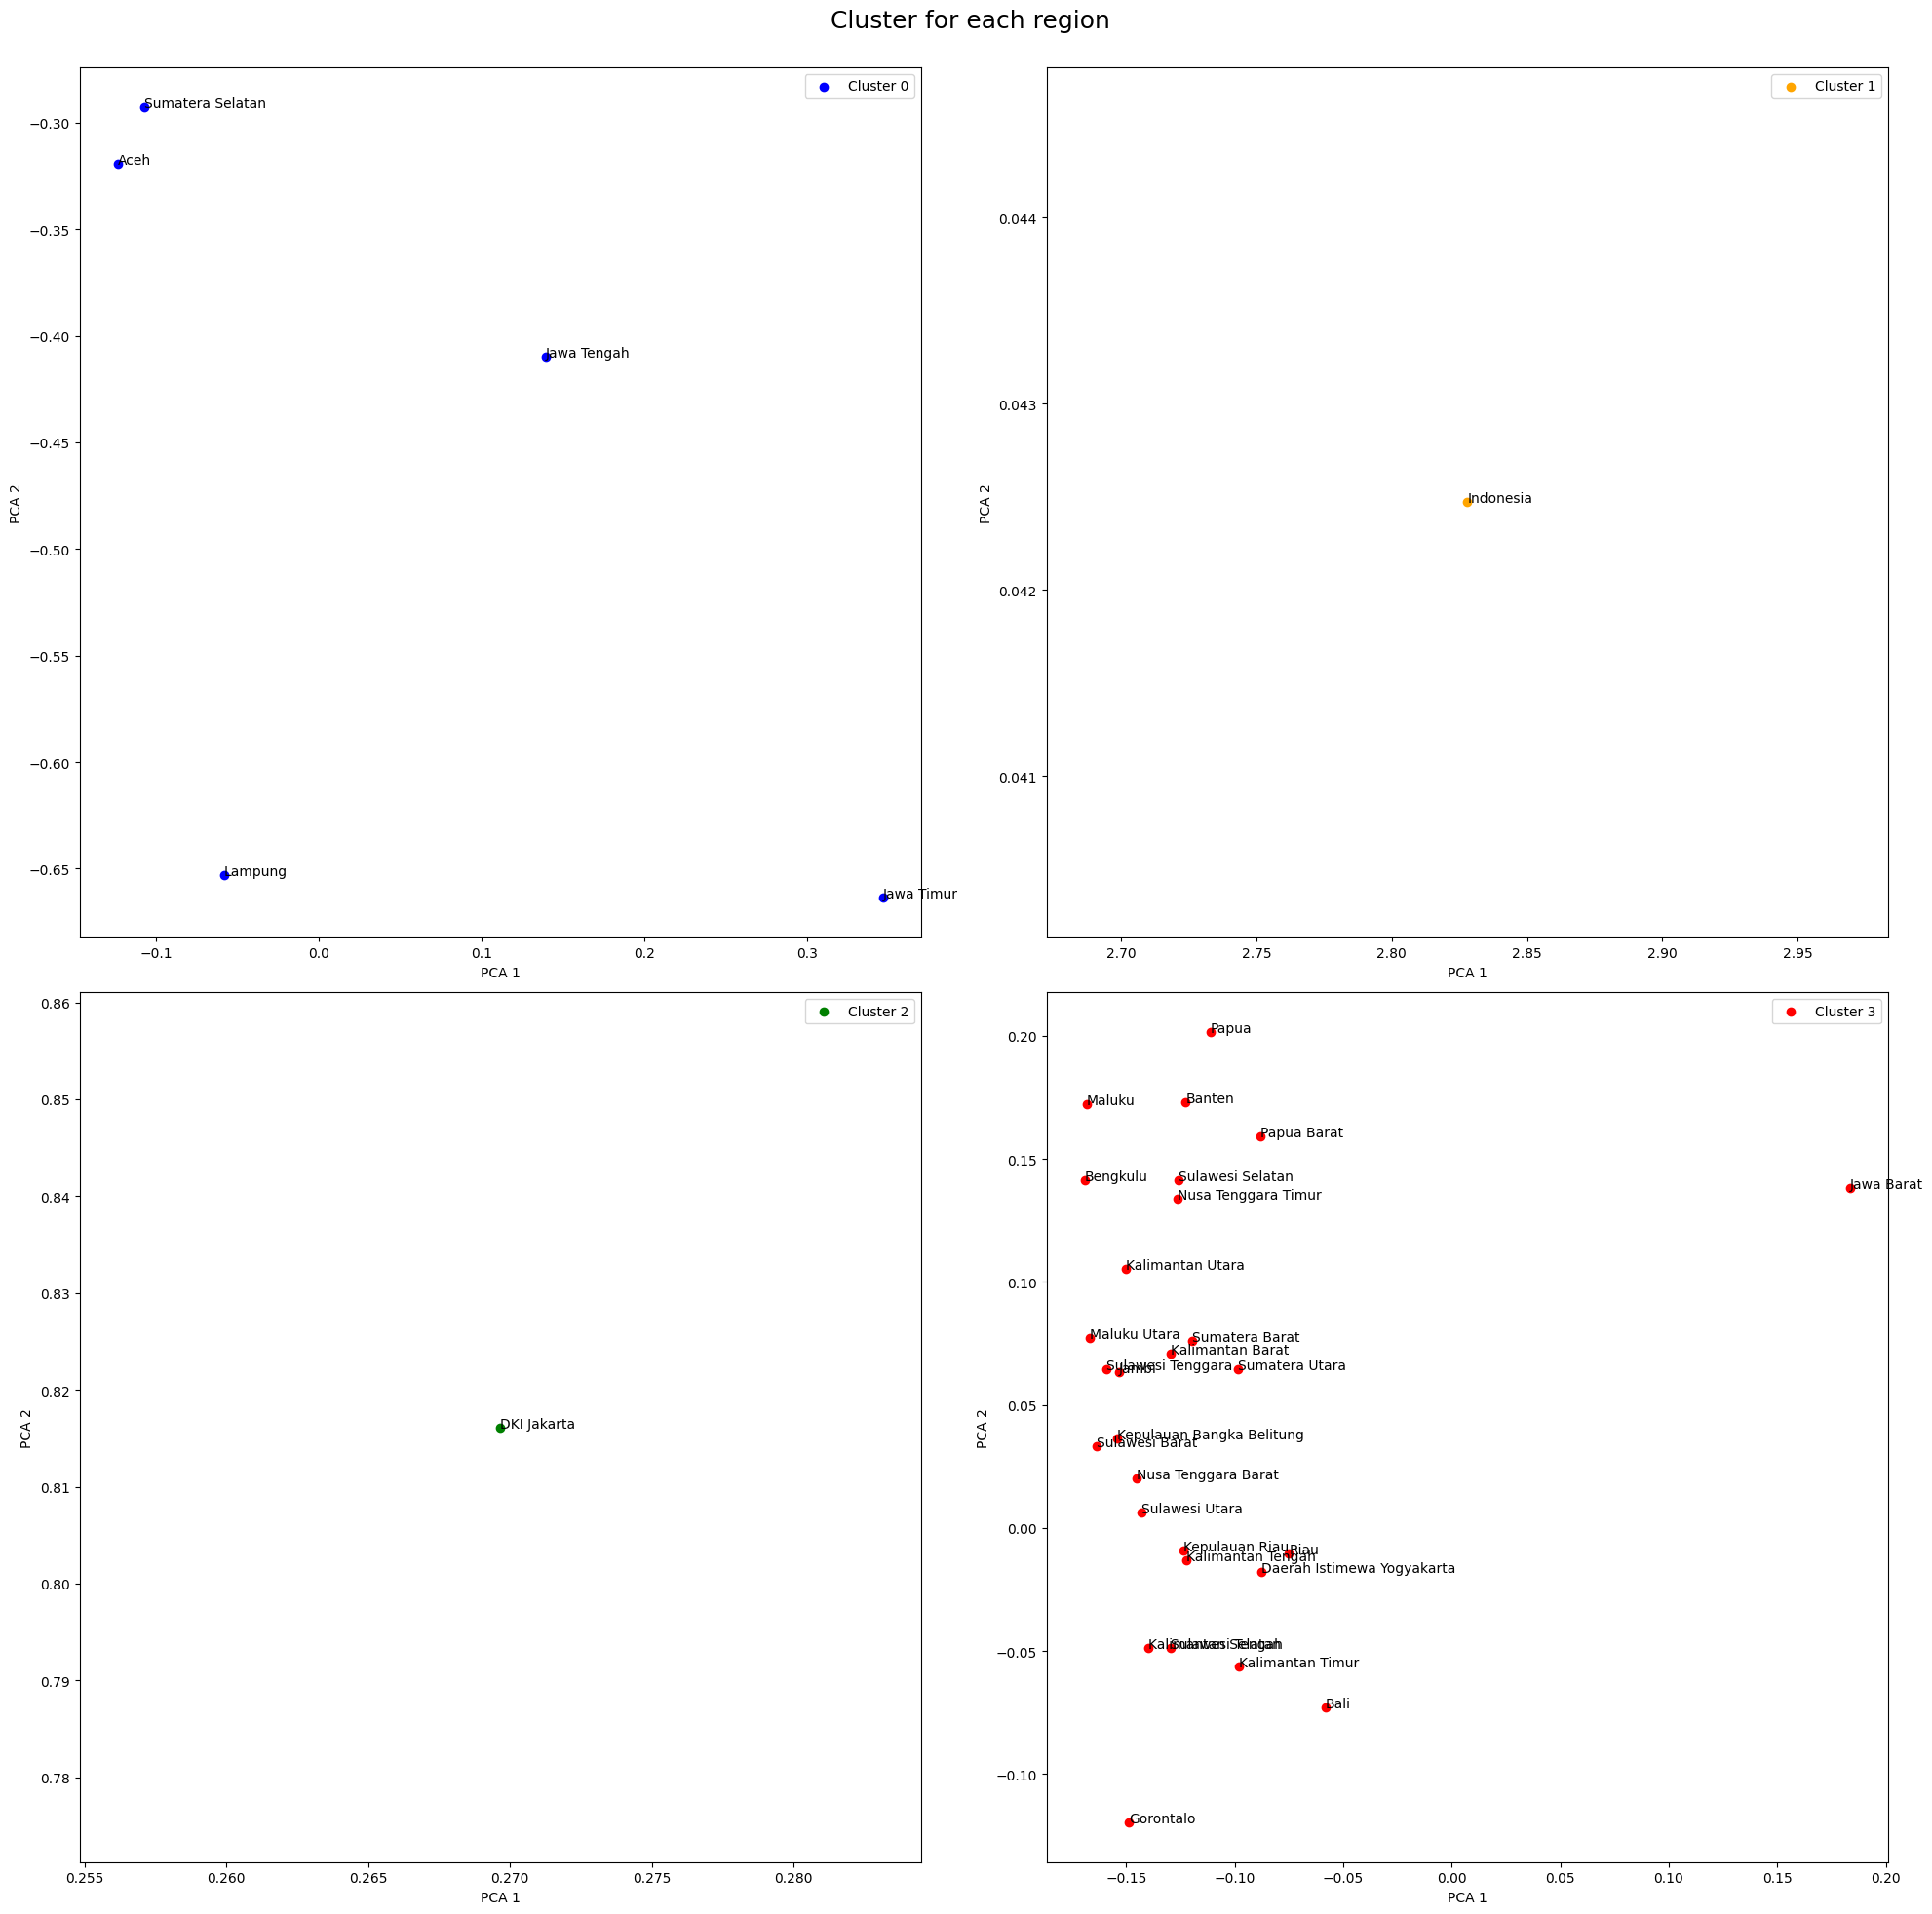

In [29]:
temp = covid21_eng

colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(20, 20))
plt.suptitle(f'Cluster for each region', fontsize=18)
for i in range(optimal_cluster):
    plt.subplot(2, 2, i+1)
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}', color=colors[i])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    for idx, row in temp.iterrows():
        plt.annotate(row['Location'], (row['PCA_1'], row['PCA_2']))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

#### Scenario 1.2: Using Standard Scaler

In [30]:
datte = '2021-12-31'

covid21_eng = covid21.copy()
covid21_eng = covid21_eng.loc[covid21_eng['Date'] == datte]
X = covid21_eng.drop(columns=['Date', 'Location'])
X = X.reset_index(drop=True)
X.head()

New Cases  New Deaths  New Recovered  New Active Cases  Total Cases  \
0          1           0              0                 1        38430   
1          3           1              3                -1       114389   
2          4           0              3                 1       132826   
3          0           0              0                 0        23105   
4         87           1              0                86       865297   

   Total Deaths  Total Recovered  Total Active Cases  Area (km2)  Population  \
0          2066            36362                   2       57956     5247257   
1          4061           110273                  55        5780     4216171   
2          2694           130128                   4        9663    10722374   
3           473            22631                   1       19919     1999539   
4         13609           851236                 452         664    10846145   

   Population Density  Case Fatality Rate  
0               90.54                5.38  
1              729.43                3.55  
2             1109.64                2.03  
3              100.38                2.05  
4            16334.31                1.57

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

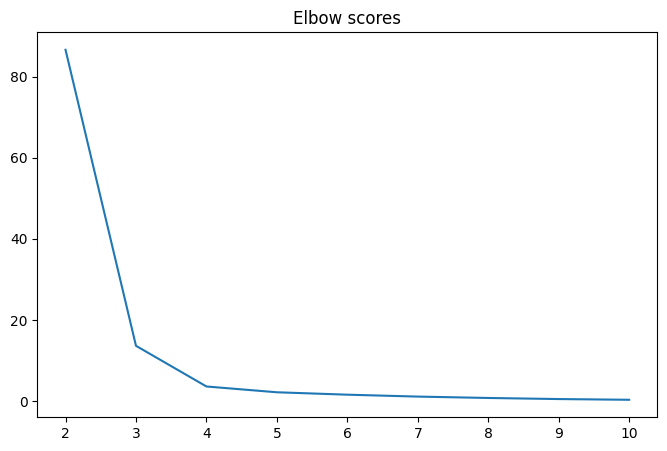

In [32]:
elbow_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    elbow_scores.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), elbow_scores)
plt.title('Elbow scores')
plt.show()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

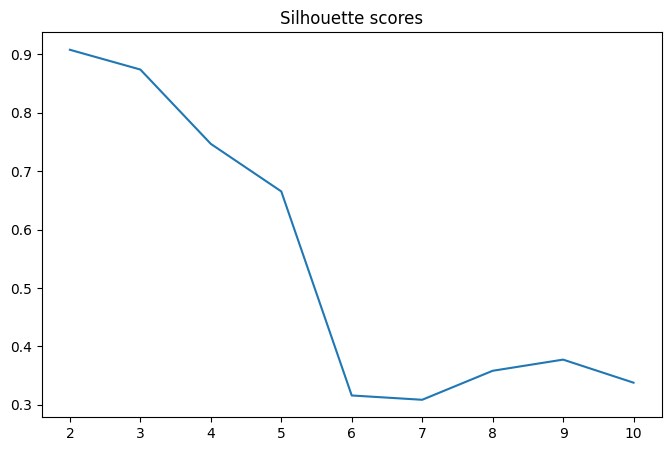

In [33]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    lab = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, lab))

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), silhouette_scores)
plt.title('Silhouette scores')
plt.show()

In [34]:
# Berdasarkan hasil elbow -> k optimal = 3
# Berdasarkan hasil silhouette -> k optimal = 2, tapi ada sedikit perbaikan di k = 3
# Keputusan cluster = 3
optimal_cluster = 3

In [35]:
kmeans = KMeans(n_clusters=optimal_cluster)
covid21_eng['Cluster'] = kmeans.fit_predict(X)
covid21_eng['PCA_1'] = X[:, 0]
covid21_eng['PCA_2'] = X[:, 1]
covid21_eng.head()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Date     Location  New Cases  New Deaths  New Recovered  \
12740 2021-12-31         Aceh          1           0              0   
12741 2021-12-31         Bali          3           1              3   
12742 2021-12-31       Banten          4           0              3   
12743 2021-12-31     Bengkulu          0           0              0   
12744 2021-12-31  DKI Jakarta         87           1              0   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
12740                 1        38430          2066            36362   
12741                -1       114389          4061           110273   
12742                 1       132826          2694           130128   
12743                 0        23105           473            22631   
12744                86       865297         13609           851236   

       Total Active Cases  Area (km2)  Population  Population Density  \
12740                   2       57956     5247257               90.54   
12741                  55        5780     4216171              729.43   
12742                   4        9663    10722374             1109.64   
12743                   1       19919     1999539              100.38   
12744                 452         664    10846145            16334.31   

       Case Fatality Rate  Cluster     PCA_1     PCA_2  
12740                5.38        1 -0.772303 -0.322305  
12741                3.55        1 -0.430343 -0.024054  
12742                2.03        1 -0.674340  0.273489  
12743                2.05        1 -0.949115 -0.040956  
12744                1.57        2  1.404069  8.222629

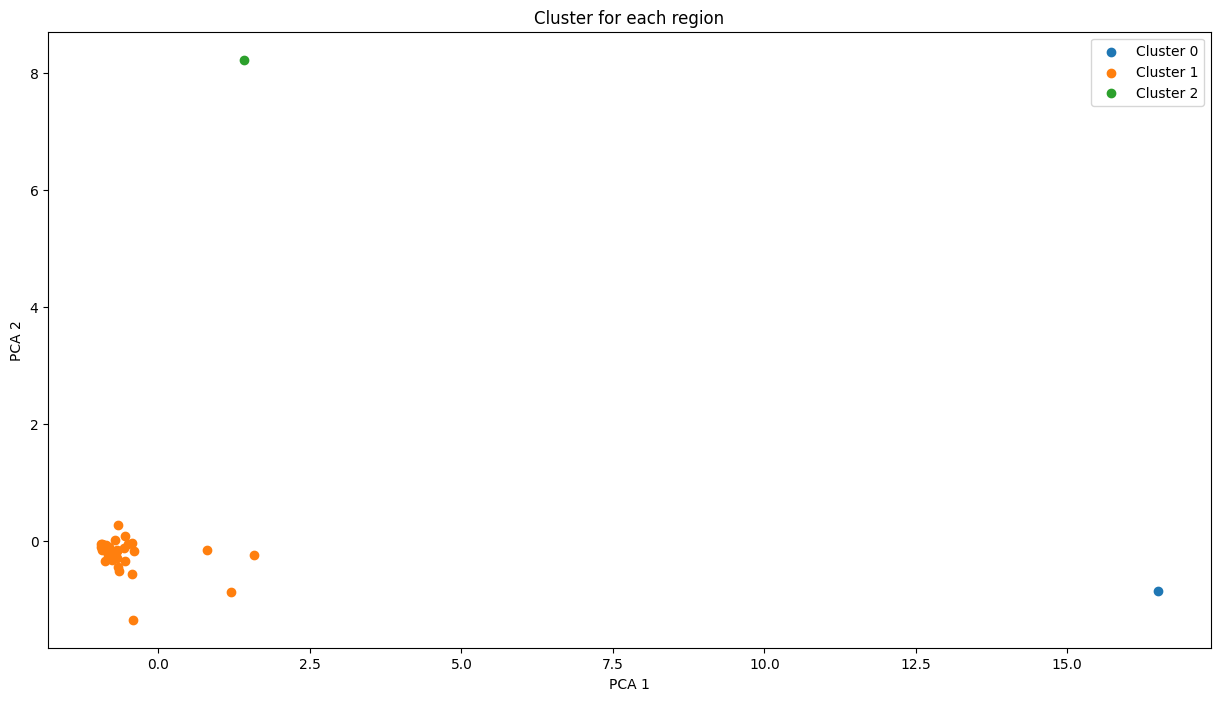

In [36]:
plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = covid21_eng['PCA_1'].loc[covid21_eng['Cluster'] == i]
    y = covid21_eng['PCA_2'].loc[covid21_eng['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

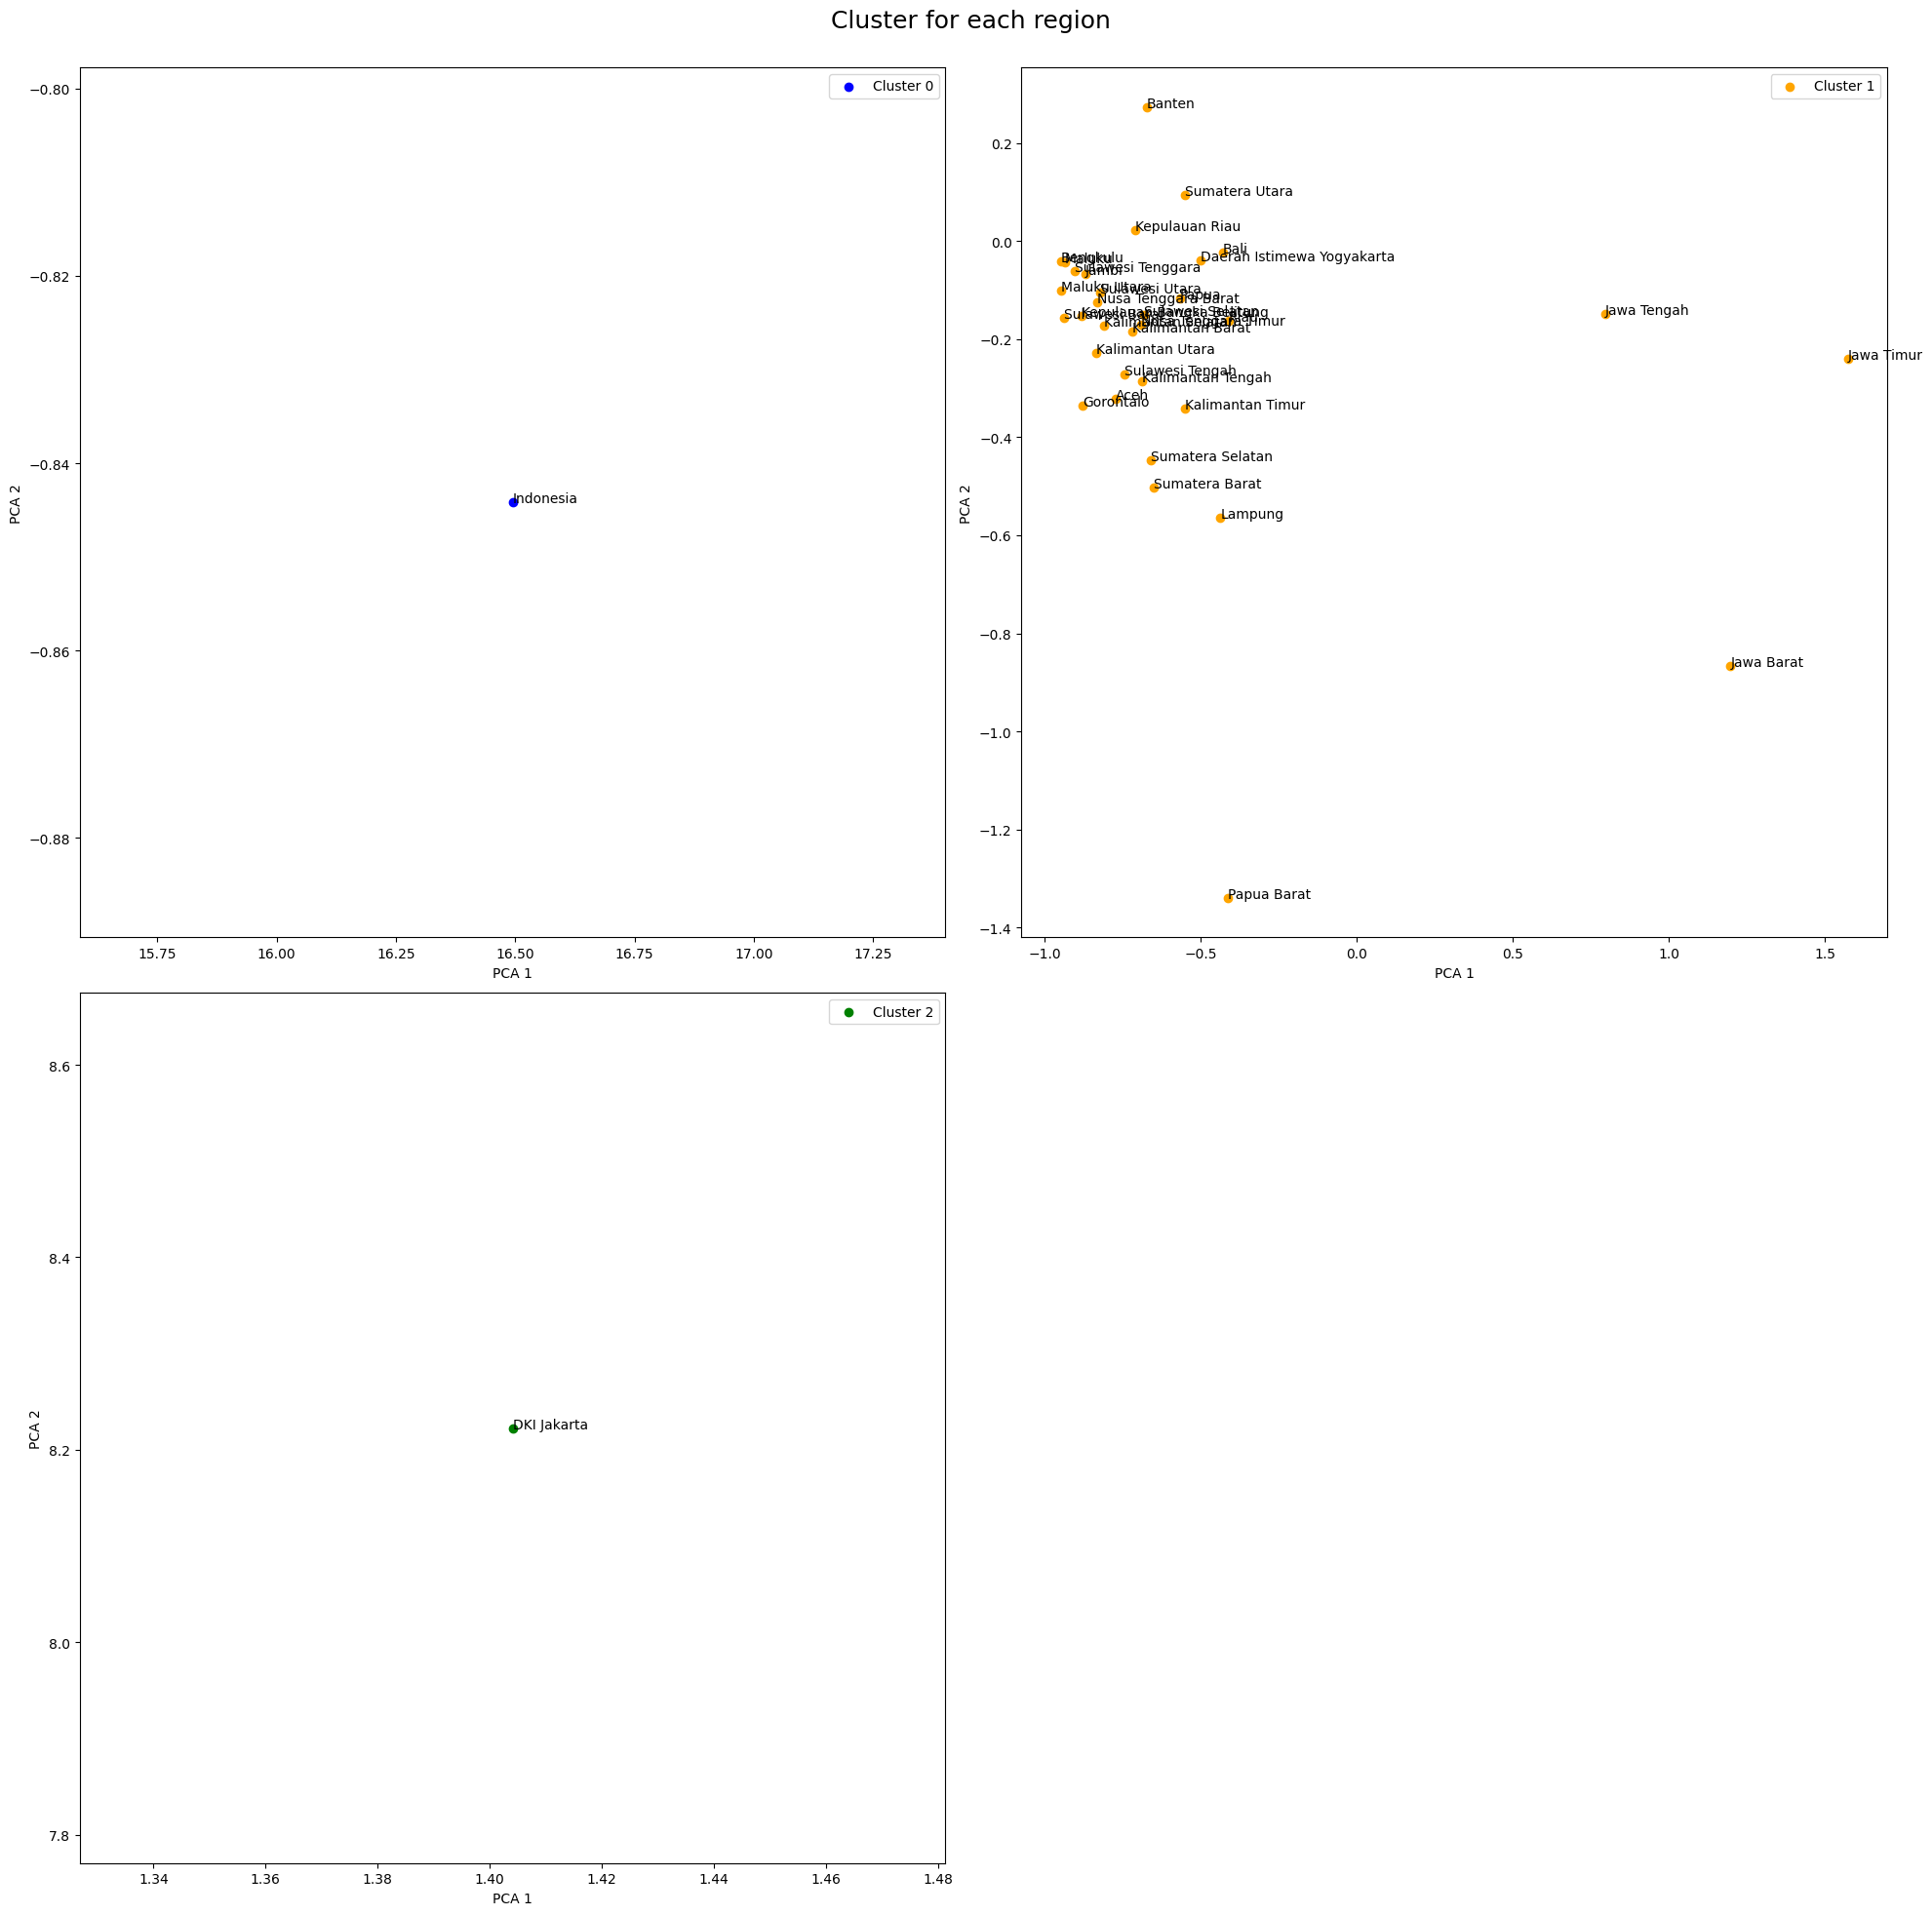

In [37]:
temp = covid21_eng

colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(20, 20))
plt.suptitle(f'Cluster for each region', fontsize=18)
for i in range(optimal_cluster):
    plt.subplot(2, 2, i+1)
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}', color=colors[i])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    for idx, row in temp.iterrows():
        plt.annotate(row['Location'], (row['PCA_1'], row['PCA_2']))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Scenario 2: Kmeans Clustering with all time data

#### Scenario 2.1: Using MinMax Scaler

In [38]:
covid21_eng = covid21.copy()
X = covid21_eng.drop(columns=['Date', 'Location'])
X = X.reset_index(drop=True)
X

New Cases  New Deaths  New Recovered  New Active Cases  Total Cases  \
0              7           0             10                -3         8753   
1            101           1             76                24        17694   
2            287          12            188                87        18441   
3             68           5             97               -34         3671   
4           1956          20           1643               293       185690   
...          ...         ...            ...               ...          ...   
12770          1           0              0                 1        20173   
12771          2           0              2                 0        34799   
12772          1           0             11               -10        89873   
12773          0           0              2                -2        59986   
12774          7           0              3                 4       106123   

       Total Deaths  Total Recovered  Total Active Cases  Area (km2)  \
0               358             7150                1245       57956   
1               517            16223                 954        5780   
2               537            15881                2023        9663   
3               117             2652                 902       19919   
4              3290           166383               16017         664   
...             ...              ...                 ...         ...   
12770           528            19638                   7       38068   
12771          1063            33633                 103       13892   
12772          2153            87704                  16       42013   
12773          3082            56889                  15       91592   
12774          2893           103178                  52       72981   

       Population  Population Density  Case Fatality Rate  
0         5247257               90.54                4.09  
1         4216171              729.43                2.92  
2        10722374             1109.64                2.91  
3         1999539              100.38                3.19  
4        10846145            16334.31                1.77  
...           ...                 ...                 ...  
12770     2635461               69.23                2.62  
12771     2641884              190.17                3.05  
12772     5519245              131.37                2.40  
12773     8217551               89.72                5.14  
12774    14874889              203.82                2.73  

[12775 rows x 12 columns]

In [39]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X

array([[-0.06370339,  0.17395722],
       [-0.08736068,  0.01234469],
       [-0.07123605,  0.00256203],
       ...,
       [-0.06471453, -0.04217702],
       [-0.02372504,  0.30592903],
       [-0.02968548, -0.00247003]])

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

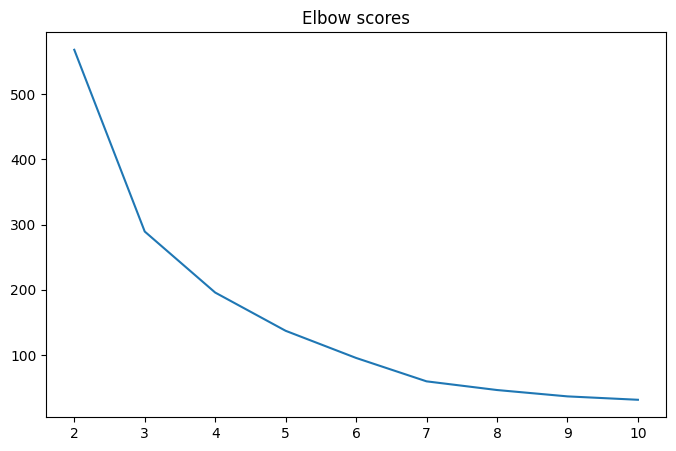

In [40]:
elbow_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    elbow_scores.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), elbow_scores)
plt.title('Elbow scores')
plt.show()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

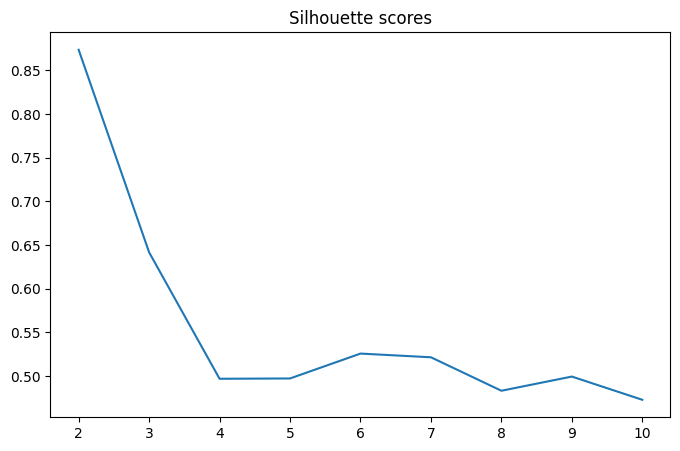

In [41]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    lab = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, lab))

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), silhouette_scores)
plt.title('Silhouette scores')
plt.show()

In [42]:
# Berdasarkan hasil elbow -> k optimal = 3
# Berdasarkan hasil silhouette -> k optimal = 2
# Keputusan cluster = 3
optimal_cluster = 3

##### Visualization with all data points

In [43]:
kmeans = KMeans(n_clusters=optimal_cluster)
covid21_eng['Cluster'] = kmeans.fit_predict(X)
covid21_eng['PCA_1'] = X[:, 0]
covid21_eng['PCA_2'] = X[:, 1]
covid21_eng

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Date           Location  New Cases  New Deaths  New Recovered  \
0     2021-01-01               Aceh          7           0             10   
1     2021-01-01               Bali        101           1             76   
2     2021-01-01             Banten        287          12            188   
3     2021-01-01           Bengkulu         68           5             97   
4     2021-01-01        DKI Jakarta       1956          20           1643   
...          ...                ...        ...         ...            ...   
12770 2021-12-31  Sulawesi Tenggara          1           0              0   
12771 2021-12-31     Sulawesi Utara          2           0              2   
12772 2021-12-31     Sumatera Barat          1           0             11   
12773 2021-12-31   Sumatera Selatan          0           0              2   
12774 2021-12-31     Sumatera Utara          7           0              3   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                    -3         8753           358             7150   
1                    24        17694           517            16223   
2                    87        18441           537            15881   
3                   -34         3671           117             2652   
4                   293       185690          3290           166383   
...                 ...          ...           ...              ...   
12770                 1        20173           528            19638   
12771                 0        34799          1063            33633   
12772               -10        89873          2153            87704   
12773                -2        59986          3082            56889   
12774                 4       106123          2893           103178   

       Total Active Cases  Area (km2)  Population  Population Density  \
0                    1245       57956     5247257               90.54   
1                     954        5780     4216171              729.43   
2                    2023        9663    10722374             1109.64   
3                     902       19919     1999539              100.38   
4                   16017         664    10846145            16334.31   
...                   ...         ...         ...                 ...   
12770                   7       38068     2635461               69.23   
12771                 103       13892     2641884              190.17   
12772                  16       42013     5519245              131.37   
12773                  15       91592     8217551               89.72   
12774                  52       72981    14874889              203.82   

       Case Fatality Rate  Cluster     PCA_1     PCA_2  
0                    4.09        2 -0.063703  0.173957  
1                    2.92        0 -0.087361  0.012345  
2                    2.91        0 -0.071236  0.002562  
3                    3.19        0 -0.089784  0.060565  
4                    1.77        0 -0.015680 -0.494544  
...                   ...      ...       ...       ...  
12770                2.62        0 -0.085786 -0.011747  
12771                3.05        0 -0.084226  0.040635  
12772                2.40        0 -0.064715 -0.042177  
12773                5.14        2 -0.023725  0.305929  
12774                2.73        0 -0.029685 -0.002470  

[12775 rows x 17 columns]

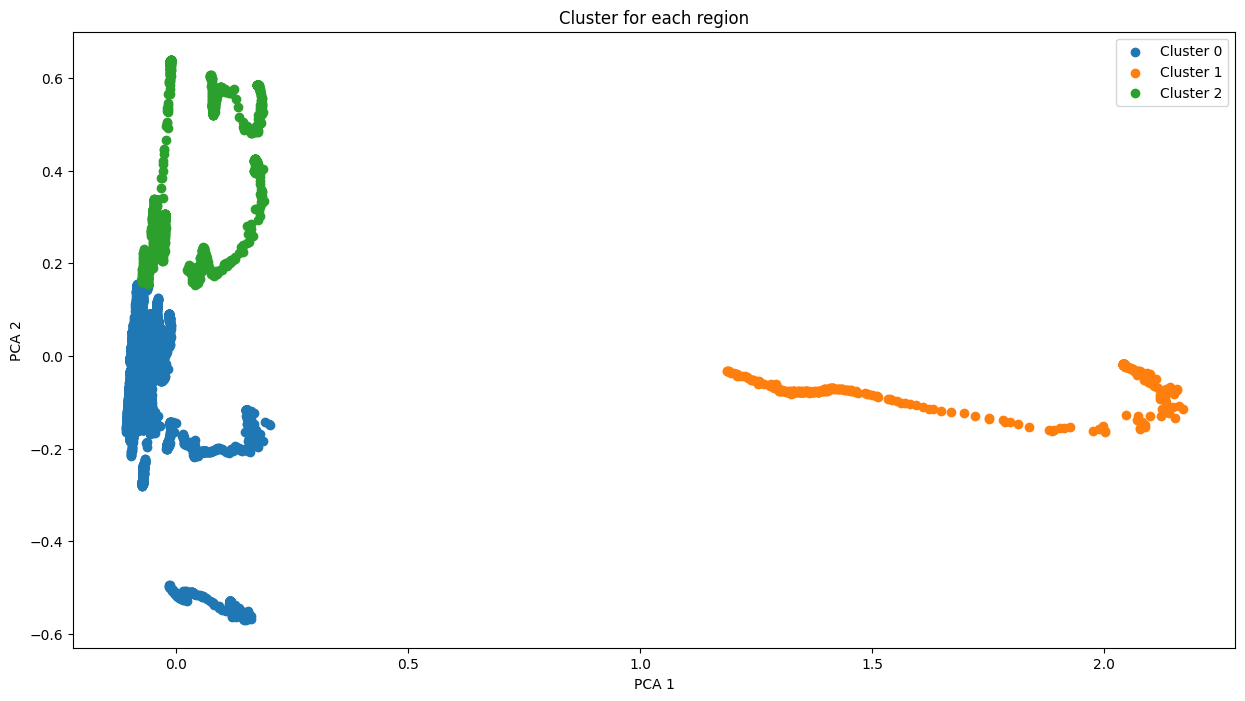

In [44]:
plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = covid21_eng['PCA_1'].loc[covid21_eng['Cluster'] == i]
    y = covid21_eng['PCA_2'].loc[covid21_eng['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

##### Visualization with certain dates data points

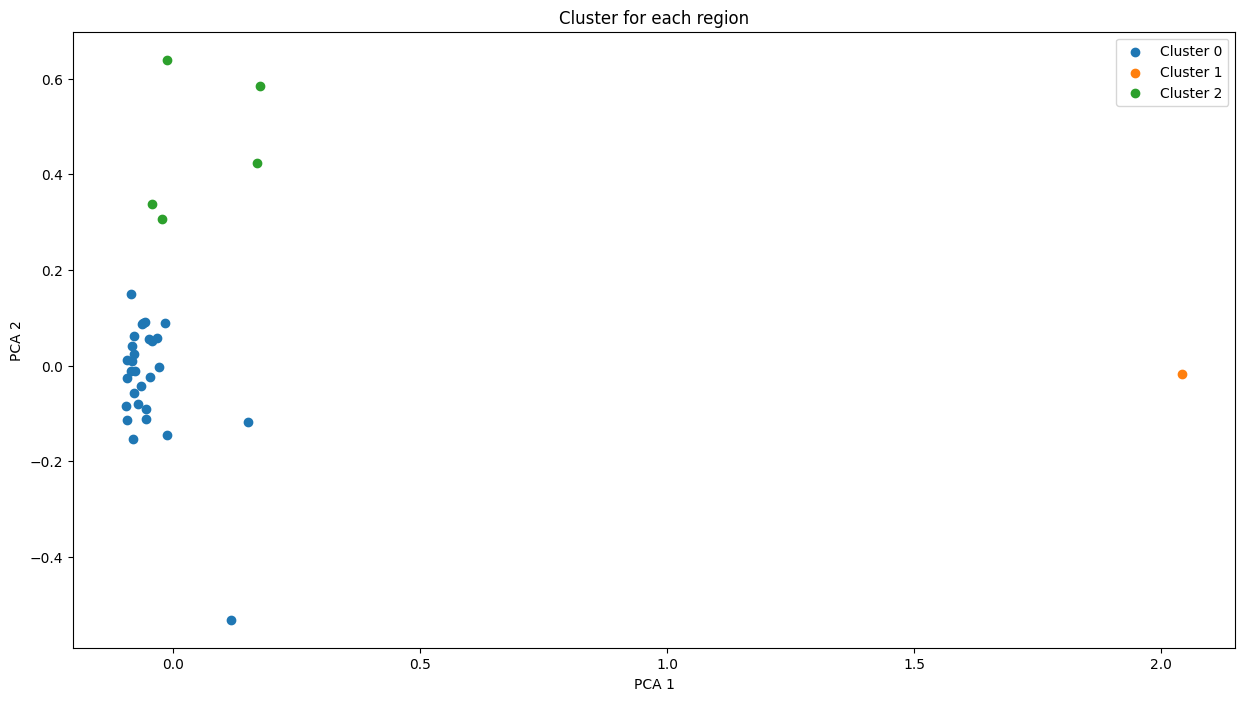

In [45]:
datte = '2021-12-31'
temp = covid21_eng.loc[covid21_eng['Date'] == datte]

plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

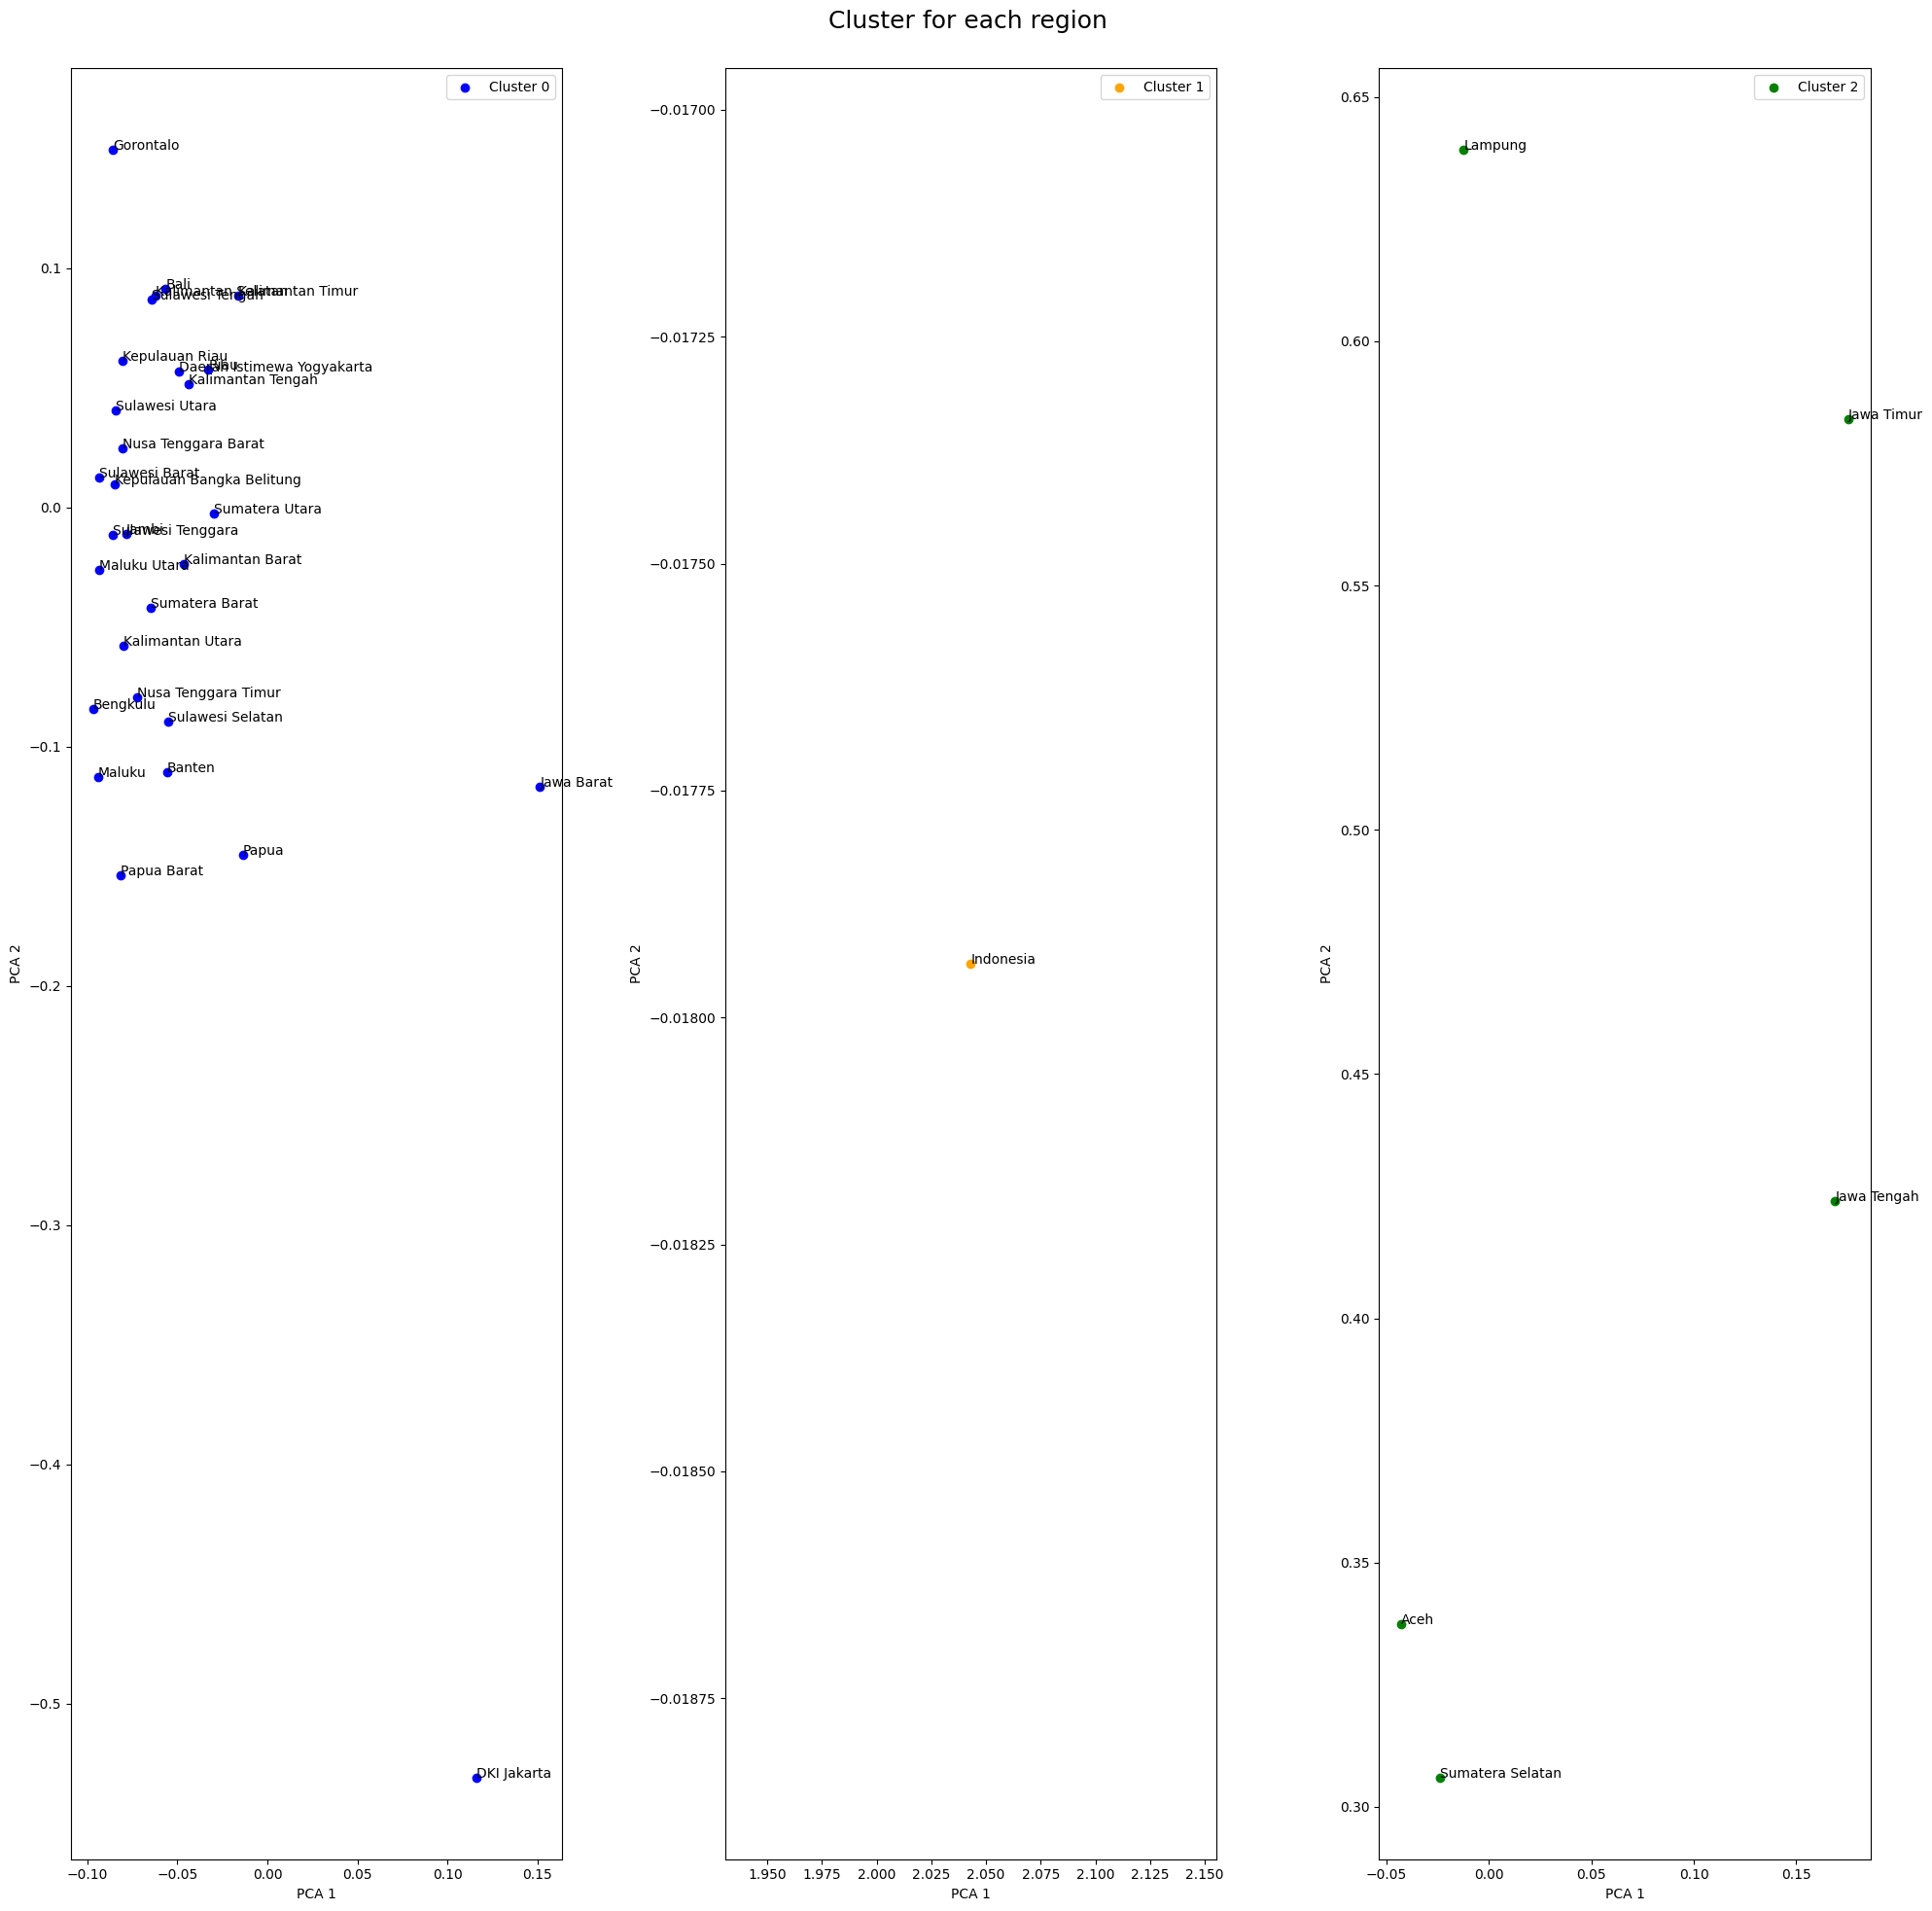

In [46]:
colors = ['blue', 'orange', 'green']
plt.figure(figsize=(20, 20))
plt.suptitle(f'Cluster for each region', fontsize=18)
for i in range(optimal_cluster):
    plt.subplot(1, 3, i+1)
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}', color=colors[i])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    for idx, row in temp.iterrows():
        plt.annotate(row['Location'], (row['PCA_1'], row['PCA_2']))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Scenario 2.2: Using Standard Scaler

In [47]:
covid21_eng = covid21.copy()
X = covid21_eng.drop(columns=['Date', 'Location'])
X = X.reset_index(drop=True)
X

New Cases  New Deaths  New Recovered  New Active Cases  Total Cases  \
0              7           0             10                -3         8753   
1            101           1             76                24        17694   
2            287          12            188                87        18441   
3             68           5             97               -34         3671   
4           1956          20           1643               293       185690   
...          ...         ...            ...               ...          ...   
12770          1           0              0                 1        20173   
12771          2           0              2                 0        34799   
12772          1           0             11               -10        89873   
12773          0           0              2                -2        59986   
12774          7           0              3                 4       106123   

       Total Deaths  Total Recovered  Total Active Cases  Area (km2)  \
0               358             7150                1245       57956   
1               517            16223                 954        5780   
2               537            15881                2023        9663   
3               117             2652                 902       19919   
4              3290           166383               16017         664   
...             ...              ...                 ...         ...   
12770           528            19638                   7       38068   
12771          1063            33633                 103       13892   
12772          2153            87704                  16       42013   
12773          3082            56889                  15       91592   
12774          2893           103178                  52       72981   

       Population  Population Density  Case Fatality Rate  
0         5247257               90.54                4.09  
1         4216171              729.43                2.92  
2        10722374             1109.64                2.91  
3         1999539              100.38                3.19  
4        10846145            16334.31                1.77  
...           ...                 ...                 ...  
12770     2635461               69.23                2.62  
12771     2641884              190.17                3.05  
12772     5519245              131.37                2.40  
12773     8217551               89.72                5.14  
12774    14874889              203.82                2.73  

[12775 rows x 12 columns]

In [48]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X

array([[-0.66254788, -0.05570905],
       [-0.70656446,  0.09502386],
       [-0.56576105,  0.17118015],
       ...,
       [-0.57355603, -0.05535862],
       [-0.47240582, -0.32129598],
       [-0.42230624, -0.17497108]])

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

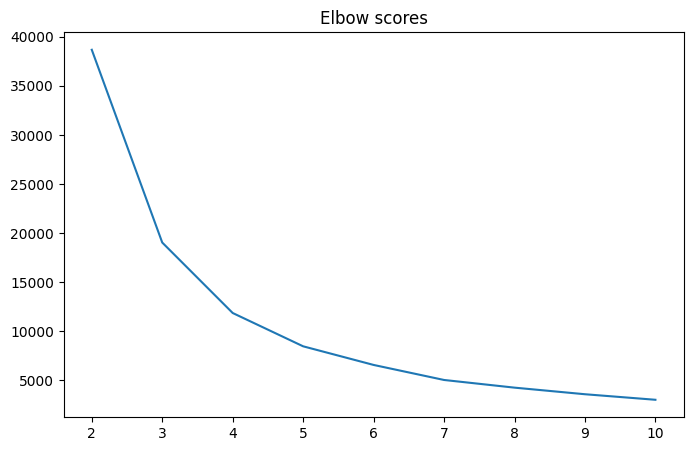

In [49]:
elbow_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    elbow_scores.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), elbow_scores)
plt.title('Elbow scores')
plt.show()

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

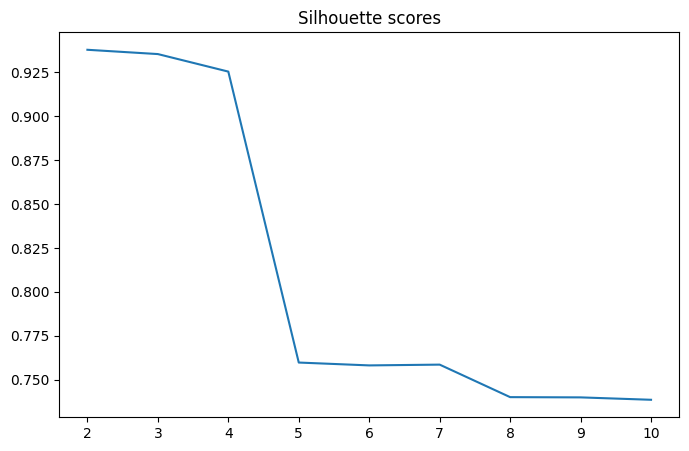

In [50]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    lab = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, lab))

plt.figure(figsize=(8, 5))
plt.plot(np.arange(2, 11), silhouette_scores)
plt.title('Silhouette scores')
plt.show()

In [51]:
# Berdasarkan hasil elbow -> k optimal = 4
# Berdasarkan hasil silhouette -> k optimal = 2, akan cluster 4 juga tidak terlalu buruk
# Keputusan cluster = 3
optimal_cluster = 4

##### Visualization with all data points

In [52]:
kmeans = KMeans(n_clusters=optimal_cluster)
covid21_eng['Cluster'] = kmeans.fit_predict(X)
covid21_eng['PCA_1'] = X[:, 0]
covid21_eng['PCA_2'] = X[:, 1]
covid21_eng

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Date           Location  New Cases  New Deaths  New Recovered  \
0     2021-01-01               Aceh          7           0             10   
1     2021-01-01               Bali        101           1             76   
2     2021-01-01             Banten        287          12            188   
3     2021-01-01           Bengkulu         68           5             97   
4     2021-01-01        DKI Jakarta       1956          20           1643   
...          ...                ...        ...         ...            ...   
12770 2021-12-31  Sulawesi Tenggara          1           0              0   
12771 2021-12-31     Sulawesi Utara          2           0              2   
12772 2021-12-31     Sumatera Barat          1           0             11   
12773 2021-12-31   Sumatera Selatan          0           0              2   
12774 2021-12-31     Sumatera Utara          7           0              3   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                    -3         8753           358             7150   
1                    24        17694           517            16223   
2                    87        18441           537            15881   
3                   -34         3671           117             2652   
4                   293       185690          3290           166383   
...                 ...          ...           ...              ...   
12770                 1        20173           528            19638   
12771                 0        34799          1063            33633   
12772               -10        89873          2153            87704   
12773                -2        59986          3082            56889   
12774                 4       106123          2893           103178   

       Total Active Cases  Area (km2)  Population  Population Density  \
0                    1245       57956     5247257               90.54   
1                     954        5780     4216171              729.43   
2                    2023        9663    10722374             1109.64   
3                     902       19919     1999539              100.38   
4                   16017         664    10846145            16334.31   
...                   ...         ...         ...                 ...   
12770                   7       38068     2635461               69.23   
12771                 103       13892     2641884              190.17   
12772                  16       42013     5519245              131.37   
12773                  15       91592     8217551               89.72   
12774                  52       72981    14874889              203.82   

       Case Fatality Rate  Cluster     PCA_1     PCA_2  
0                    4.09        0 -0.662548 -0.055709  
1                    2.92        0 -0.706564  0.095024  
2                    2.91        0 -0.565761  0.171180  
3                    3.19        0 -0.725480  0.101766  
4                    1.77        0  0.399004  0.651152  
...                   ...      ...       ...       ...  
12770                2.62        0 -0.726877  0.064925  
12771                3.05        0 -0.711416  0.009855  
12772                2.40        0 -0.573556 -0.055359  
12773                5.14        0 -0.472406 -0.321296  
12774                2.73        0 -0.422306 -0.174971  

[12775 rows x 17 columns]

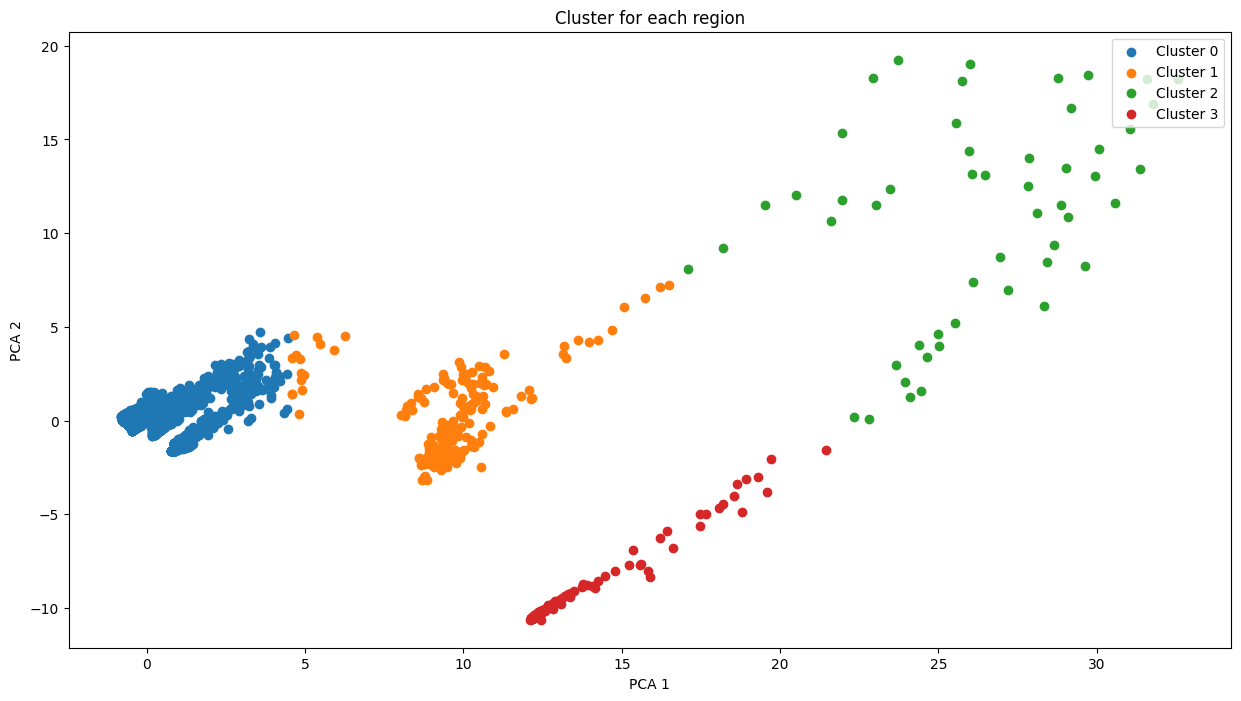

In [53]:
plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = covid21_eng['PCA_1'].loc[covid21_eng['Cluster'] == i]
    y = covid21_eng['PCA_2'].loc[covid21_eng['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

##### Visualization with certain dates data points

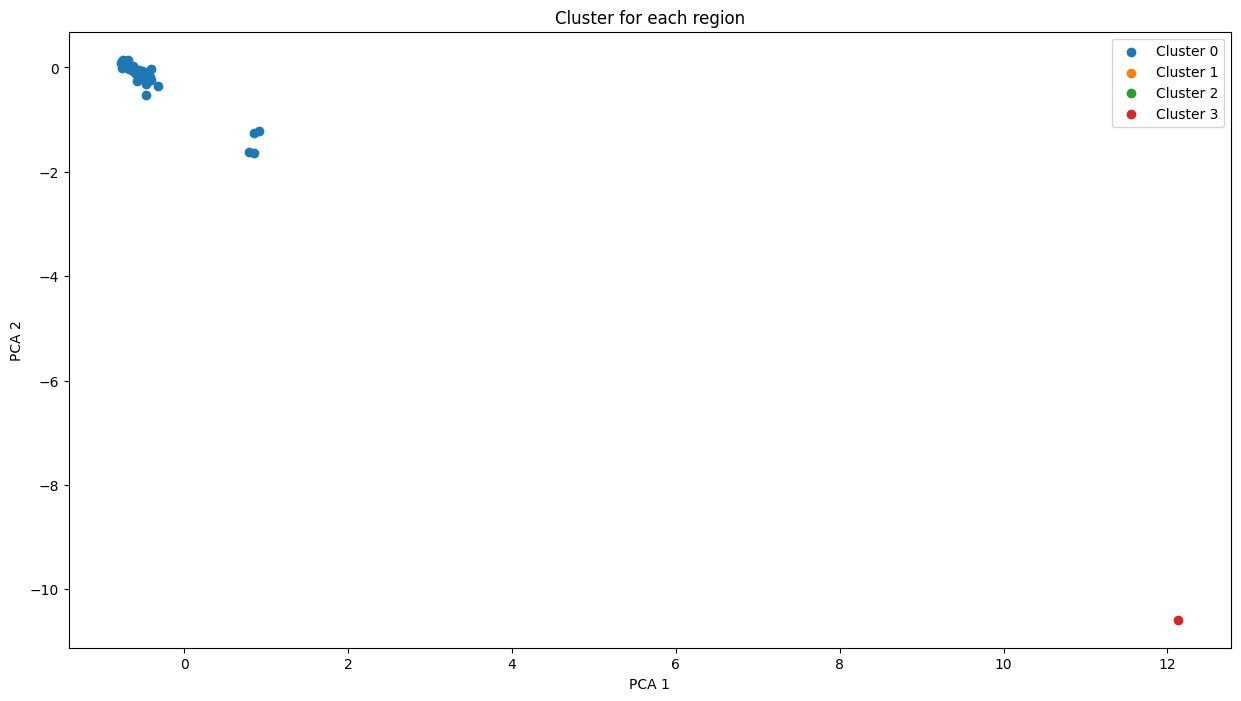

In [54]:
datte = '2021-12-31'
temp = covid21_eng.loc[covid21_eng['Date'] == datte]

plt.figure(figsize=(15, 8))
plt.title(f'Cluster for each region')
for i in range(optimal_cluster):
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc='upper right')
plt.show()

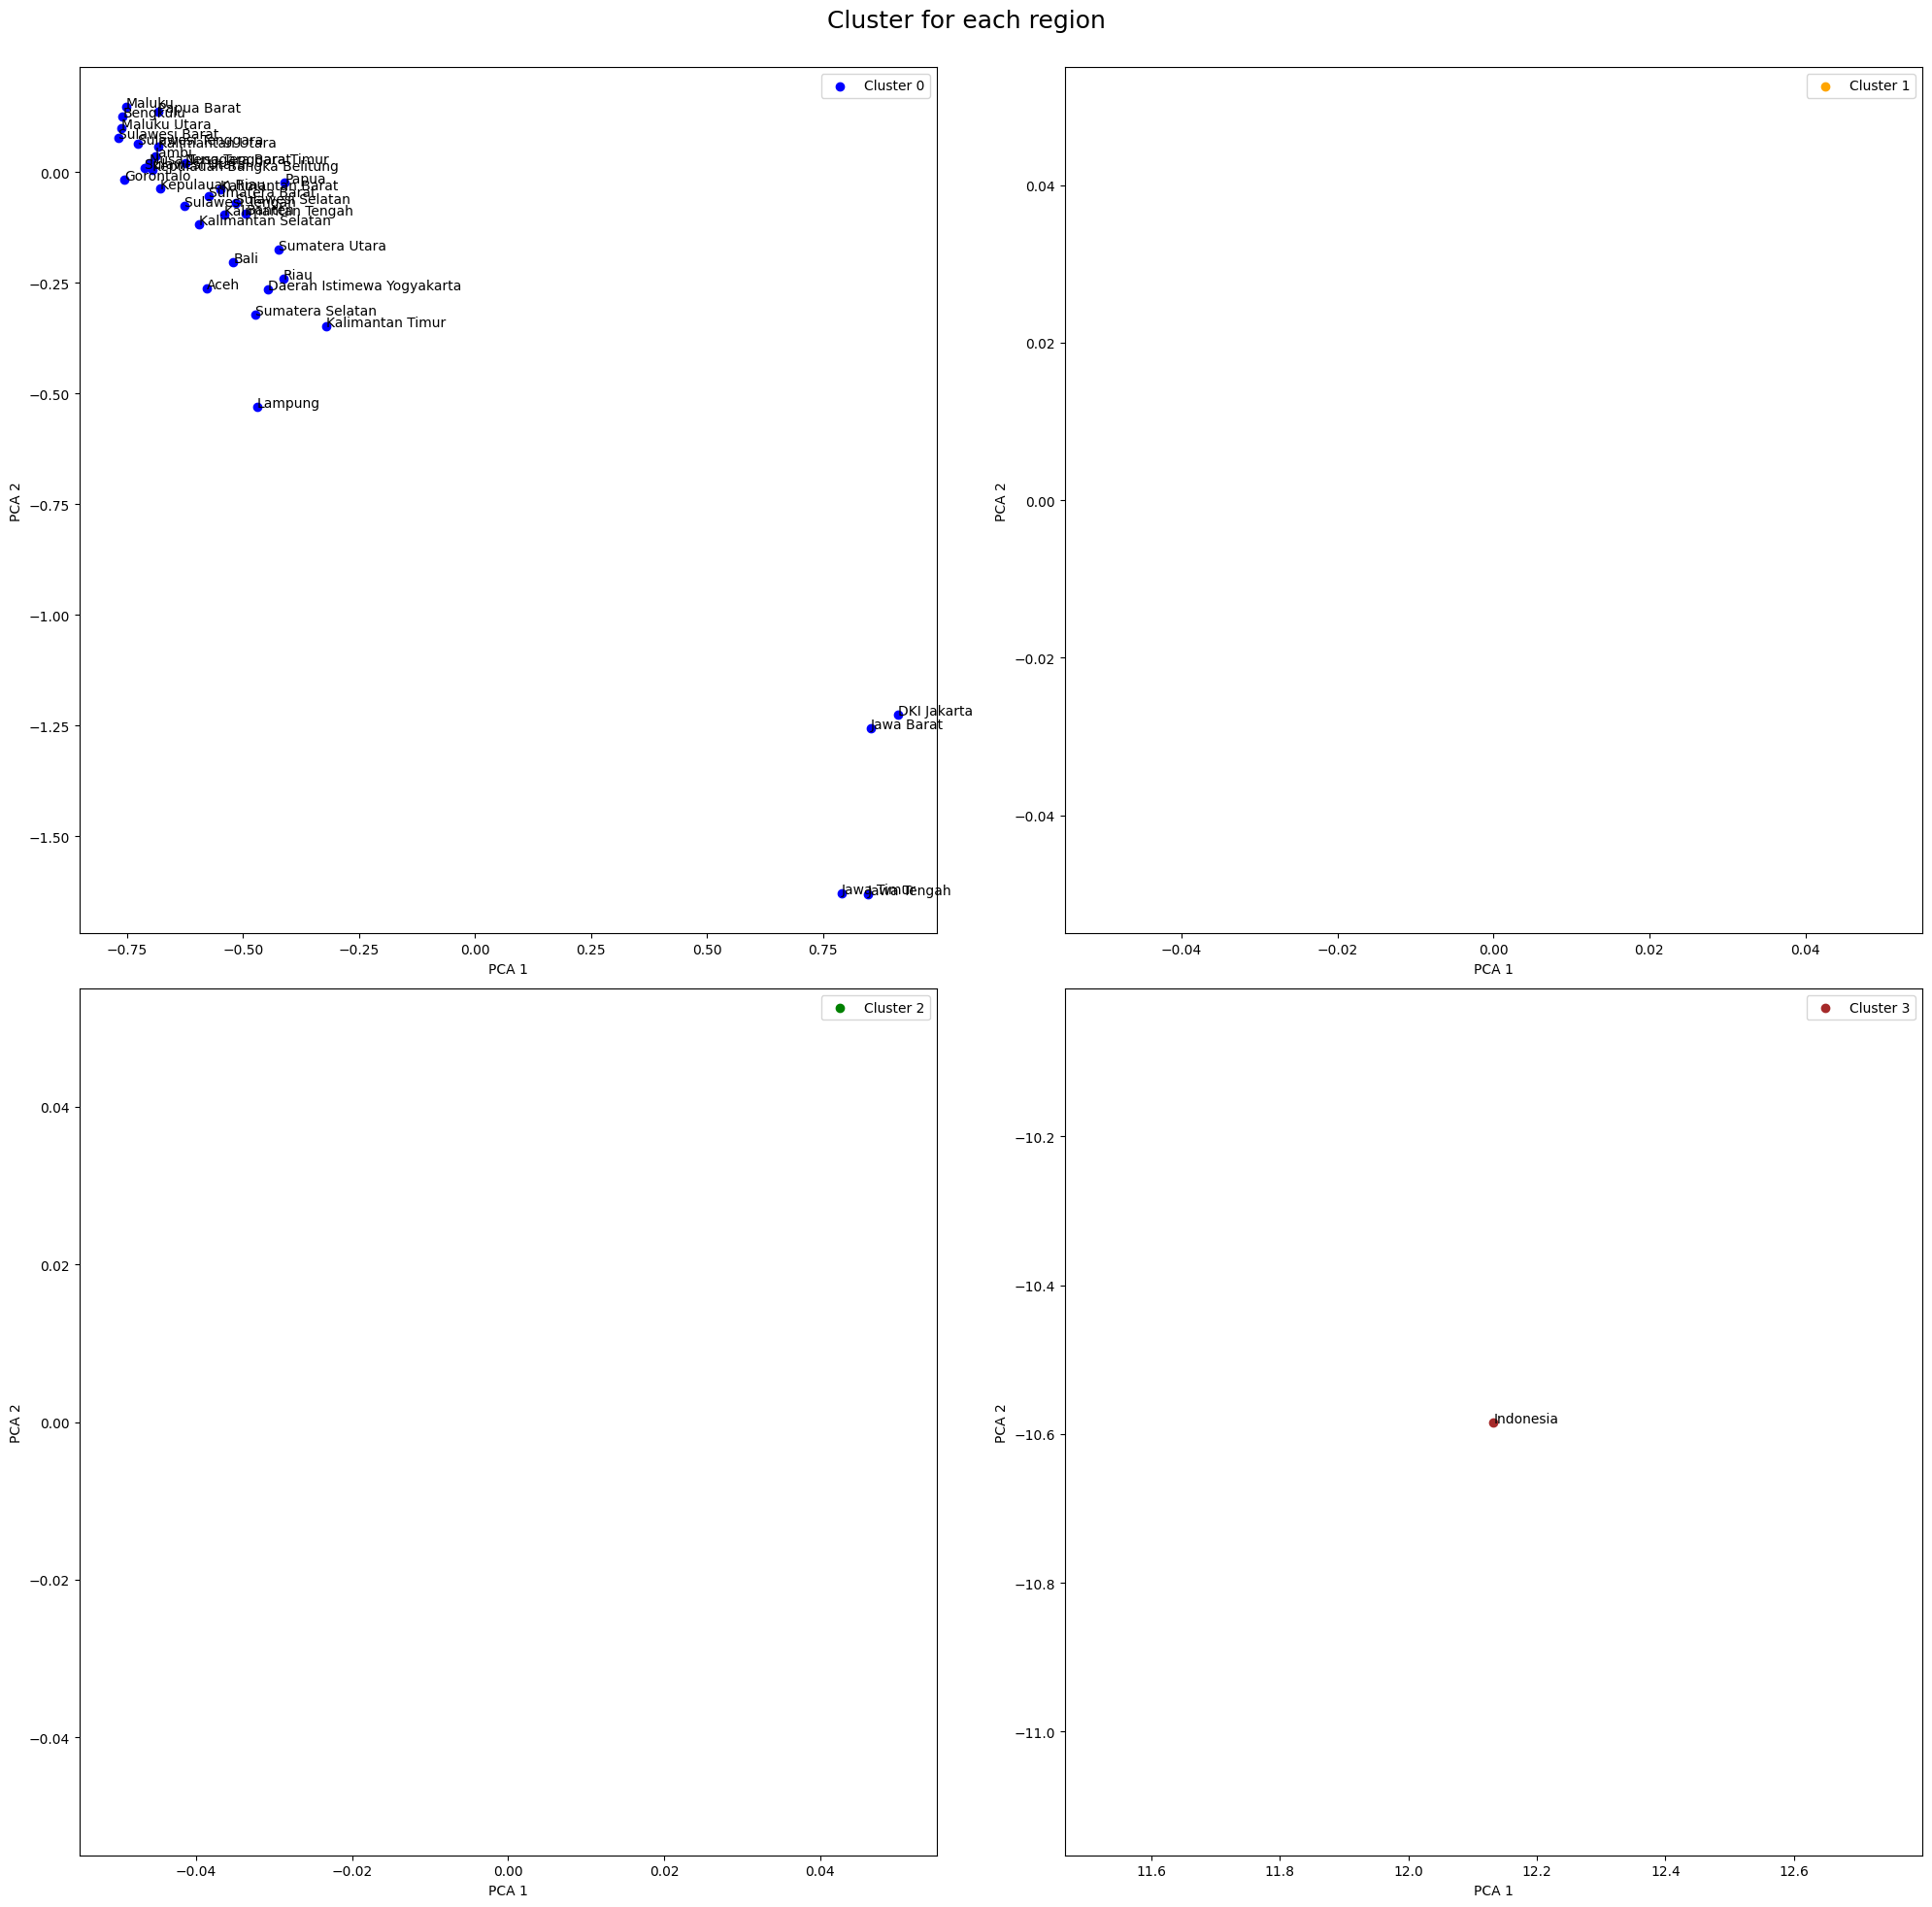

In [55]:
colors = ['blue', 'orange', 'green', 'brown']
plt.figure(figsize=(20, 20))
plt.suptitle(f'Cluster for each region', fontsize=18)
for i in range(optimal_cluster):
    plt.subplot(2, 2, i+1)
    x = temp['PCA_1'].loc[temp['Cluster'] == i]
    y = temp['PCA_2'].loc[temp['Cluster'] == i]
    plt.scatter(x, y, label=f'Cluster {i}', color=colors[i])
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    for idx, row in temp.iterrows():
        plt.annotate(row['Location'], (row['PCA_1'], row['PCA_2']))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()